In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import pandas as pd
from scipy import ndimage
import pmesh
from mpi4py import MPI
from nbodykit.algorithms import FFTPower
import matplotlib.gridspec as gridspec
from scipy import signal
from scipy.special import eval_legendre
from nbodykit.binned_statistic import BinnedStatistic

%load_ext autoreload
%autoreload 2

/home/groups/tabel/mahlet/nbody-env/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Load the data for a particular mock (sample from the Latin Hypercube (LH)).

In [2]:
tag_params = '_p5_n10000'
idx_LH = 0

# change this directory path as needed
dir_mocks = f'/scratch/users/kstoreyf/muchisimocks/muchisimocks_lib{tag_params}'
subdir_prefix = 'LH'
fn_fields = f'{dir_mocks}/{subdir_prefix}{idx_LH}/bias_fields_eul_deconvolved_{idx_LH}.npy'
fn_fields_zspace = f'{dir_mocks}/{subdir_prefix}{idx_LH}/bias_fields_eul_zspace_deconvolved_{idx_LH}.npy'

bias_terms_eul = np.load(fn_fields)
bias_terms_eul_zspace = np.load(fn_fields_zspace)

Define plotting code

In [3]:
# copied from plotter.py (so that this notebook is self-contained)
def plot_field(tracer_field, normalize=False, vmin=None, vmax=None, 
                title=None, show_labels=True, show_colorbar=True,
                zslice_min=0, zslice_max=1, figsize=(6,6), log=False, symlog=False, 
                overdensity=True, label_cbar=None, plot = 'xy', interpolation = None):

        if normalize:
            tracer_field /= np.max(np.abs(tracer_field))
        
        if vmax is None:
            vmax = 3*np.std(tracer_field)
       
        if tracer_field.ndim==3:
            if plot == 'xy':
                field_2d = np.mean(tracer_field[:,:,zslice_min:zslice_max], axis=-1)
            elif plot == 'xz':
                field_2d = np.mean(tracer_field[:,zslice_min:zslice_max,:], axis=1)
            elif plot == 'yz':
                field_2d = np.mean(tracer_field[zslice_min:zslice_max,:,:], axis=0)
        elif tracer_field.ndim==2:
            field_2d = tracer_field
        else:
            raise ValueError("field must be 2d or 3d!")

        plt.figure(figsize=figsize, facecolor=(1,1,1,0))
        plt.title(title, fontsize=16)
        
        if symlog:
            from matplotlib.colors import SymLogNorm
            linthresh = 0.1*vmax
            linscale = 1.0
            if vmin is None:
                vmin = -vmax
            norm = SymLogNorm(
                    linthresh=linthresh, linscale=linscale,
                    vmin=vmin, vmax=vmax
                    )
        elif log:
            if vmin is None:
                vmin = np.min(tracer_field[tracer_field>0])
            norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
        else:
            if vmin is None:
                if overdensity:
                    vmin = -vmax
                else:
                    vmin = np.min(tracer_field[tracer_field>0])
            norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

        if overdensity:
            cmap = 'RdBu'
        else:
            cmap = 'Blues'
                
        im = plt.imshow(field_2d, norm=norm, cmap=cmap, interpolation = interpolation)
        ax = plt.gca()        
        
        if show_colorbar:
            if label_cbar is None:
                if overdensity:
                    label_cbar = r'overdensity $\delta$'
                else:
                    label_cbar = r'density'
            cbar = plt.colorbar(im, label=label_cbar, fraction=0.046, pad=0.04)
            cbar.ax.tick_params(labelsize=12) 
            
        if not show_labels:    
            ax.axes.get_xaxis().set_visible(False)
            ax.axes.get_yaxis().set_visible(False)

        plt.show()

Plot the individual five bias fields

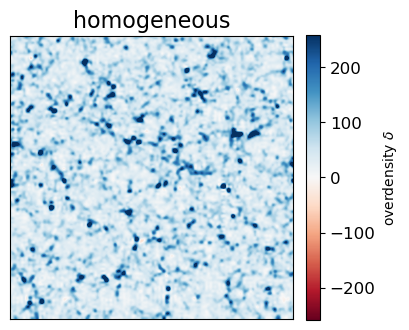

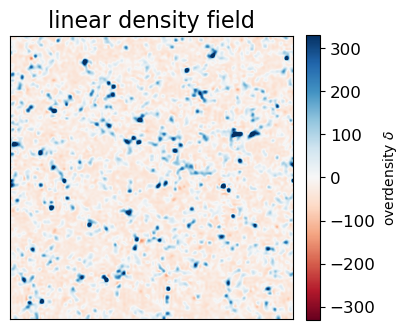

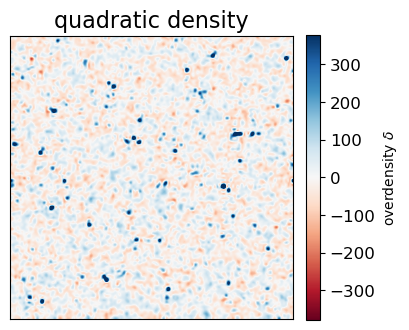

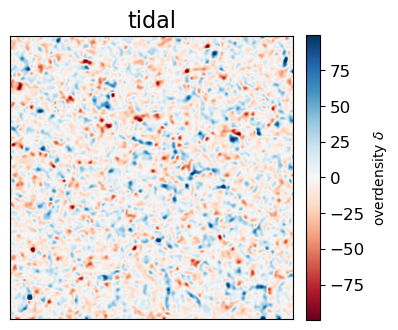

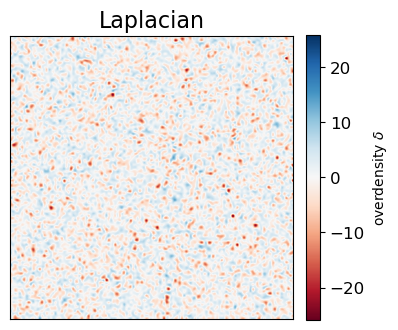

In [4]:
bias_field_labels = ['homogeneous', 'linear density field', 'quadratic density', 'tidal', 'Laplacian']
for i in range(len(bias_terms_eul)):
    plot_field(bias_terms_eul[i], figsize=(4,4), title=bias_field_labels[i], interpolation = 'bicubic',
                       show_labels=False)

Define code to combine the fields

In [5]:
# copied from utils.py (so that this notebook is self-contained)
def get_tracer_field(bias_fields_eul, bias_vector, n_grid_norm=None):
    assert len(bias_vector)==bias_fields_eul.shape[0]-1, "bias_vector must have length one less than number of bias fields"
    if n_grid_norm is None:
        n_grid_norm = bias_fields_eul.shape[-1]
        
    def _sum_bias_fields(fields, bias_vector):
        bias_vector_extended = np.concatenate(([1.0], bias_vector))
        return np.sum([fields[ii]*bias_vector_extended[ii] for ii in range(len(fields))], axis=0)
    
    tracer_field_eul = _sum_bias_fields(bias_fields_eul, bias_vector)
    tracer_field_eul_norm = tracer_field_eul/n_grid_norm**3
    
    return tracer_field_eul_norm

Choose some bias vector and combine the bias fields into a tracer field

In [6]:
#the order is b1, b2, bs2, blaplacian
bias_params = [1, 0.5, 0.5, 0.5]
# use 512 for normalization, because this is the original resolution of the mocks (they were downsampled to 128)
# this doesn't matter for visualization, but will when you go to compute statistics
n_grid_orig = 512
tracer_field_eul_norm = get_tracer_field(bias_terms_eul, bias_params, n_grid_norm=n_grid_orig)

Plot final tracer field

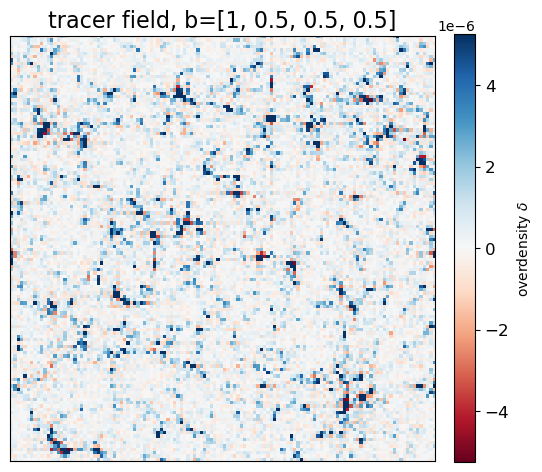

In [7]:
plot_field(tracer_field_eul_norm, figsize=(6,6), title=f'tracer field, b={bias_params}', plot = 'xz',
                   show_labels=False, vmin=-5.25e-6, vmax=5.25e-6)

Now plot in redshift-space! 

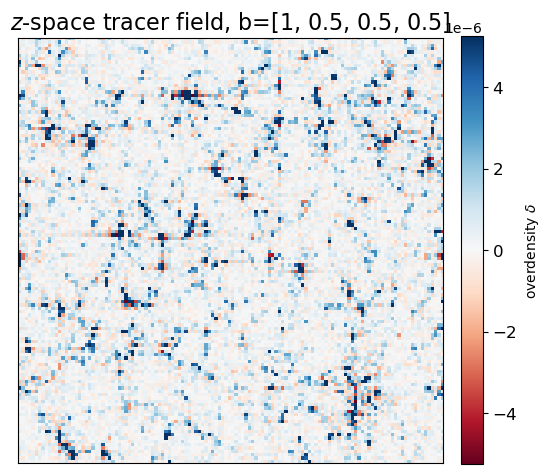

In [8]:
tracer_field_eul_norm_zspace = get_tracer_field(bias_terms_eul_zspace, bias_params, n_grid_norm=n_grid_orig)

plot_field(tracer_field_eul_norm_zspace, figsize=(6,6), title=rf'$z$-space tracer field, b={bias_params}', plot = 'xz',
                   show_labels=False, vmin=-5.25e-6, vmax=5.25e-6)

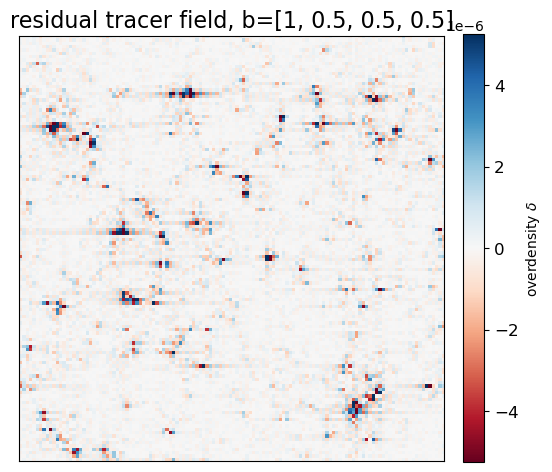

In [9]:
plot_field(tracer_field_eul_norm-tracer_field_eul_norm_zspace, figsize=(6,6), title=rf'residual tracer field, b={bias_params}', plot = 'xz',
                   show_labels=False, vmin=-5.25e-6, vmax=5.25e-6)

Read in the cosmological parameters associated with this mock

In [10]:
# copied from data_loader.py (so that this notebook is self-contained)
def load_cosmo_params(tag_params, dir_params='../data/params'):
    fn_params = f'{dir_params}/params_lh{tag_params}.txt'
    fn_params_fixed = f'{dir_params}/params_fixed{tag_params}.txt'
    
    params_df = (
        pd.read_csv(fn_params, index_col=0)
        if os.path.exists(fn_params)
        else None
    )
    param_dict_fixed = (
        pd.read_csv(fn_params_fixed).iloc[0].to_dict() 
        if os.path.exists(fn_params_fixed)
        else {}
    )
    return params_df, param_dict_fixed

In [11]:
# the mock directory should contain these parameter files; or they might be in a central directory (default)
params_df, param_dict_fixed = load_cosmo_params(tag_params=tag_params, dir_params=dir_mocks)

In [12]:
print('fixed parameters:')
for key in param_dict_fixed.keys():
    print(f'{key}: {param_dict_fixed[key]:.3f}')

fixed parameters:
neutrino_mass: 0.000
w0: -1.000
wa: 0.000


In [13]:
print('parameters varied in LH:')
param_dict_vary = params_df.loc[idx_LH].to_dict()
for key in param_dict_vary.keys():
    print(f'{key}: {param_dict_vary[key]:.3f}')

parameters varied in LH:
omega_cold: 0.237
sigma8_cold: 0.698
hubble: 0.664
omega_baryon: 0.049
ns: 0.957


# Construct the fields in z space

## $\delta_{\mathrm{g}}(\vec{s}) \equiv\left(1-f_s\right) \delta_{\mathrm{g}}\left(\vec{s}_c\right)+f_s \delta_{\mathrm{g}}\left(\vec{s}_c\right) *_z \exp \left(-\lambda_{\mathrm{FoG}} \mathrm{~s}_{\mathrm{z}}\right)$

## Decide kernel length

In [14]:
Lbox = 1000 # h/Mpc
Nbox = len(tracer_field_eul_norm_zspace)
lambda_FOG = 0.3 # Mpc/h
f_sat = 0.7
N = 30
norm = 128**6

In [15]:
def Lkernel_func(N = N, Lbox = Lbox, Nbox = Nbox):
    
    return Lbox/Nbox*N # Mpc/h

def s_z_func(N = N, Lbox = Lbox, Nbox = Nbox):

    Lkernel = Lkernel_func(N)
    s_z = np.linspace(-Lkernel/2, Lkernel/2, N+1) # Mpc/h

    if np.diff(s_z)[0] != Lbox/Nbox:
        raise TypeError("make sure the kernel spacing matches the grid spacing")

    return s_z

def kernel_func(s_z, lambda_FOG = lambda_FOG):

    # normalize the kernel
    kernel = np.exp(-lambda_FOG*np.abs(s_z))
    norm = np.sum(kernel)

    return kernel/norm

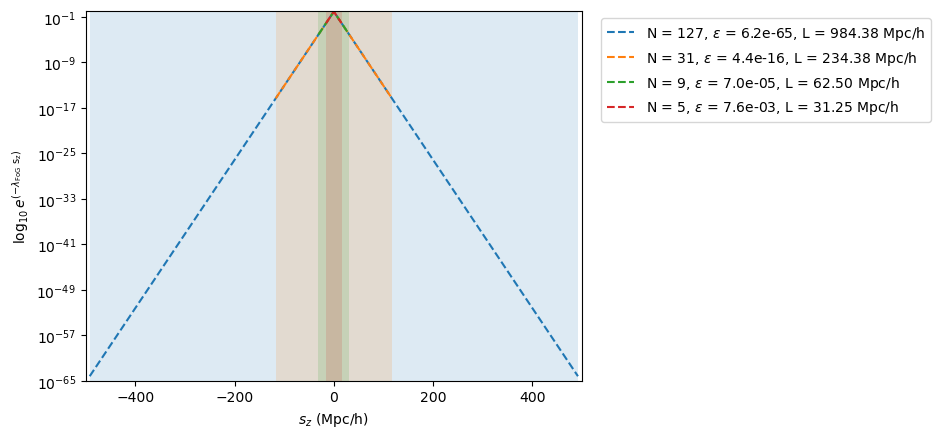

In [16]:
ymin, ymax = 1e-65, 1

for N_kernel in [Nbox-2, N, 8, 4]:
    s_z = s_z_func(N_kernel)
    kernel = kernel_func(s_z)
    Lkernel = Lkernel_func(N_kernel)

    plt.plot(s_z, kernel, label = 'N = {:d}, $\epsilon$ = {:.1e}, L = {:.2f} Mpc/h'.format(N_kernel + 1, kernel[0], Lkernel), linestyle = '--')
    plt.fill_betweenx(np.linspace(ymin, ymax), -Lkernel/2, Lkernel/2, alpha = 0.15)
    
plt.xlim(-Lbox/2, Lbox/2)
plt.ylim(ymin, ymax)
plt.yscale('log')
plt.xlabel('$s_z$ (Mpc/h)')
plt.ylabel('$\log_{10}e^{(-\lambda_{\mathrm{FoG}} \mathrm{~s}_{\mathrm{z}})}$')
plt.legend(bbox_to_anchor=(1.025, 1.0))
plt.show()

## Measure the power spectrum with and without RSDs 

In [17]:
def RSD(tracer_field_eul_norm_zspace, tracer_field_eul_norm, ax0 = None, ax1 = None, f_sat = 0.7, lambda_FOG = 0.3, alpha = 1, i = 0, 
        plot = True, N = N, Lbox = Lbox, Nbox = Nbox, title = None, norm = norm):
    
    # Start with large-scale RSDs
    RSD_large = tracer_field_eul_norm_zspace*(1-f_sat)
    if plot == True:
        plot_field(RSD_large, figsize=(6,6), title=r'$(1-f_s) \delta_{\mathrm{g}}(\vec{s}_c)$', plot = 'xz',
                   show_labels=False)
    
    # Now compute small-scale RSDs
    RSD_small = f_sat*ndimage.convolve1d(tracer_field_eul_norm_zspace, kernel_func(s_z_func(N), lambda_FOG), mode = 'wrap')
    if plot == True:
        plot_field(RSD_small, figsize=(6,6), title=r'$f_s \delta_{\mathrm{g}}(\vec{s}_c) *_z e^{(-\lambda_{\mathrm{FoG}} \mathrm{~s}_{\mathrm{z}})}$',
                   show_labels=False, plot = 'xz')
        
    # Add them together to get full RSDs
    delta_FOG = RSD_large+RSD_small
    if plot == True:
        plot_field(delta_FOG, figsize=(6,6), title=rf'$\delta_\mathrm{{tr}}^\mathrm{{FOG}}$, b={bias_params}', plot = 'xz',
                       show_labels=False)
        
    # Plot clustering
    def power_spectrum_err(tracer_field_eul_norm_zspace, label, color, comm = MPI.COMM_WORLD, linestyle = '-'): #sm
        
        def lin_pk_func(tracer_field_eul_norm_zspace):

            pm = pmesh.pm.ParticleMesh([Nbox, Nbox, Nbox], Lbox, dtype='float32', resampler='cic', comm=comm)

            # initialize a RealField
            gal_field = pmesh.pm.RealField(pm)
            gal_field[...]=tracer_field_eul_norm_zspace

            # Create the FFTPower objects
            lin_pk = FFTPower(gal_field.r2c(), '1d', kmin = 1e-5)

            # k arrays are set like this
            kvals = lin_pk.power['k'] # let's ignore the artificial zero k value

            return lin_pk.power['power'].real*norm, kvals

        lin_pk_z, kvals_z = lin_pk_func(tracer_field_eul_norm_zspace)
        lin_pk_real, kvals_real = lin_pk_func(tracer_field_eul_norm)

        if (kvals_z!=kvals_real).any():
            raise TypeError("make sure the kvals are the same")

        # Plot the P(k)
        ax0.loglog(kvals_z, lin_pk_z, linestyle = linestyle, label = label, alpha = alpha, color = color) # lin_pk.power['power'].real[1:]

        # Plot the ratio
        ax1.plot(kvals_z, lin_pk_z/lin_pk_real, linestyle = linestyle, label = label, alpha = alpha, color = color) # lin_pk.power['power'].real[1:]
        
        if i == 0:
            ax0.set_xlim(kvals_z[0], kvals_z[-1])
            ax0.set_ylabel('$P(k)$ (Mpc$/h)^3$')
            ax0.legend()
            ax0.set_xticks([])
            ax0.set_title(title)
            # ax0.set_ylim(8e-10, 5e-8)
            
            ax1.set_xscale('log')
            ax1.set_xlim(kvals_z[0], kvals_z[-1])
            ax1.set_ylim(0.75, 1.2)
            ax1.set_xlabel('$k (h/$Mpc)')
            ax1.set_ylabel('$P(k)_\mathrm{z}/P(k)_\mathrm{real}$')
        
        return kvals_z
        
    if plot == True:
        
        fig = plt.figure()
        gs = gridspec.GridSpec(2, 1, height_ratios = [4,1])
        gs.update(hspace = 0)

        ax0 = fig.add_subplot(gs[0])
        ax1 = fig.add_subplot(gs[1])

    power_spectrum_err(delta_FOG, label = 'z-space (central distortion + FOG)', color = 'red')
    power_spectrum_err(tracer_field_eul_norm_zspace, label = 'z-space (central distortion)', color = 'blue')
    kvals_z = power_spectrum_err(tracer_field_eul_norm, label = 'real-space', color = 'green')
    
    return kvals_z

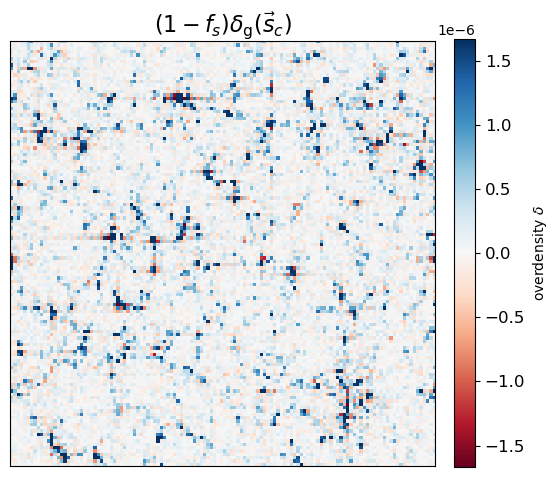

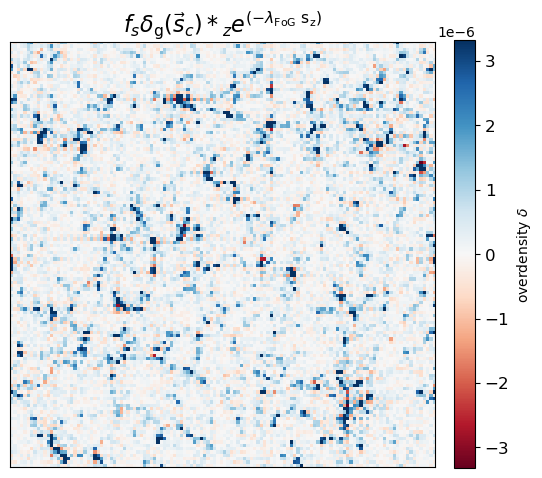

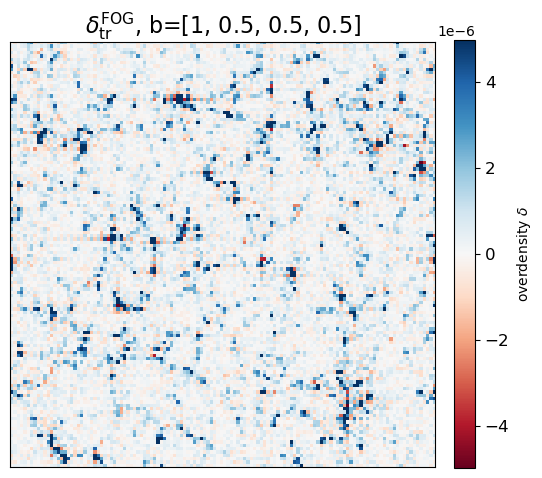

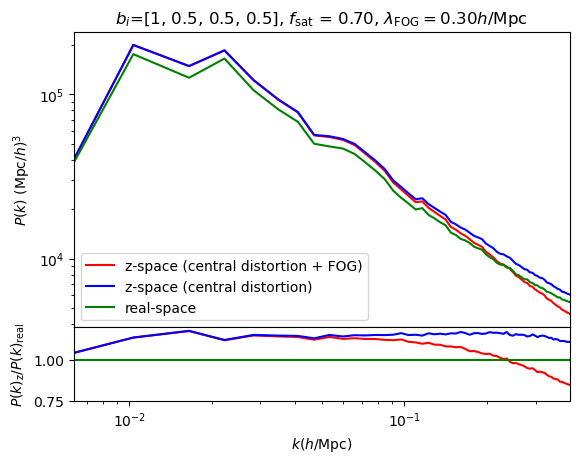

In [18]:
plot = True
lambda_FOG = 0.3
f_sat = 0.7
if plot == False:
    fig = plt.figure()
    gs = gridspec.GridSpec(2, 1, height_ratios = [4,1])
    gs.update(hspace = 0)

    ax0 = fig.add_subplot(gs[0])
    ax1 = fig.add_subplot(gs[1])

    RSD(tracer_field_eul_norm_zspace, tracer_field_eul_norm, ax0, ax1, plot = plot, lambda_FOG = lambda_FOG,
        title = '$b_i$={:s}, $f_\mathrm{{sat}}$ = {:.2f}, $\lambda_\mathrm{{FOG}}={:.2f} h/$Mpc'.format(str(bias_params), f_sat, lambda_FOG))
else:
    RSD(tracer_field_eul_norm_zspace, tracer_field_eul_norm, lambda_FOG = lambda_FOG,
        title = '$b_i$={:s}, $f_\mathrm{{sat}}$ = {:.2f}, $\lambda_\mathrm{{FOG}}={:.2f} h/$Mpc'.format(str(bias_params), f_sat, lambda_FOG))
plt.show()

## See the impact of $f_\mathrm{sat}$

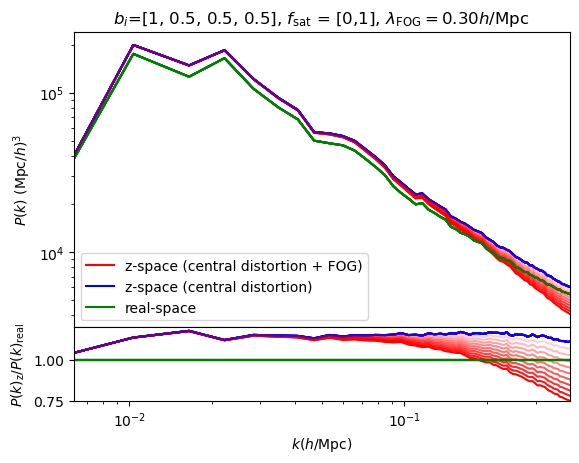

In [19]:
plot = False
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios = [4,1])
gs.update(hspace = 0)

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

f_sats = np.linspace(1,0,11)
alpha =  np.linspace(1,0.1,11)
for i in range(len(f_sats)):
    RSD(tracer_field_eul_norm_zspace, tracer_field_eul_norm, ax0, ax1, f_sat = f_sats[i], i = i, plot = plot, alpha = alpha[i], 
        title = '$b_i$={:s}, $f_\mathrm{{sat}}$ = [0,1], $\lambda_\mathrm{{FOG}}={:.2f} h/$Mpc'.format(str(bias_params), lambda_FOG))
plt.show()

## See the impact of $\lambda_\mathrm{FOG}$

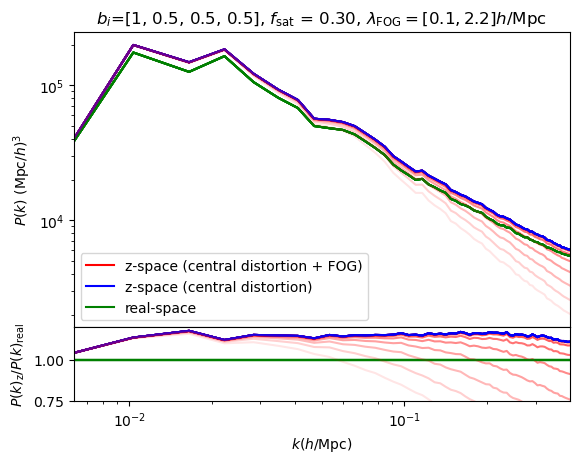

In [20]:
plot = False
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios = [4,1])
gs.update(hspace = 0)

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

lambda_FOGs = np.logspace(np.log10(2.2),-1,11)
for i in range(len(lambda_FOGs)):
    kvals_z = RSD(tracer_field_eul_norm_zspace, tracer_field_eul_norm, ax0, ax1, lambda_FOG = lambda_FOGs[i], i = i, plot = plot, 
                  alpha = alpha[i], 
                  title = '$b_i$={:s}, $f_\mathrm{{sat}}$ = {:.2f}, $\lambda_\mathrm{{FOG}}=[0.1,2.2] h/$Mpc'.format(str(bias_params), lambda_FOG))
plt.show()

### See impact on kernel

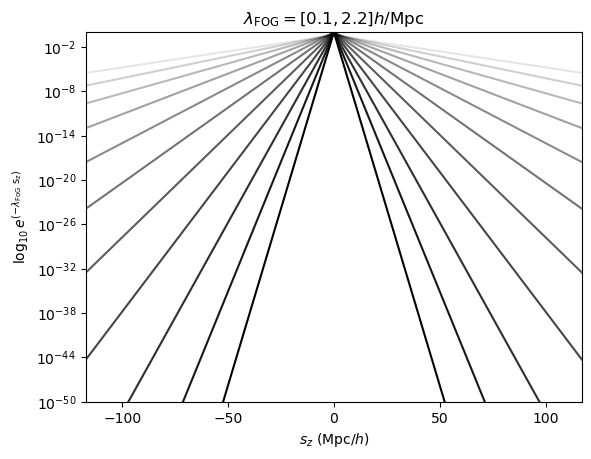

In [21]:
ymin, ymax = 1e-50, 1

for i in range(len(lambda_FOGs)):
    s_z = s_z_func(N)
    kernel = kernel_func(s_z, lambda_FOG = lambda_FOGs[i])
    Lkernel = Lkernel_func(N)

    plt.plot(s_z, kernel, label = 'N = {:d}, $\epsilon$ = {:.1e}, L = {:.2f} Mpc/h'.format(N + 1, kernel[0], Lkernel), 
             alpha = alpha[i], color = 'black')
    
plt.title('$\lambda_\mathrm{{FOG}}=[0.1,2.2] h/$Mpc'.format(lambda_FOG))
plt.xlim(-Lkernel/2, Lkernel/2)
plt.ylim(ymin, ymax)
plt.yscale('log')
plt.xlabel('$s_z$ (Mpc$/h)$')
plt.ylabel('$\log_{10}e^{(-\lambda_{\mathrm{FoG}} \mathrm{~s}_{\mathrm{z}})}$')
plt.show()

### See impact on power spectrum via damping function

In [22]:
def damp(kvals_z, lambda_FOG):
    
    return lambda_FOG**2/(lambda_FOG**2+kvals_z**2)
    # return (1/(1+kvals_z**2/lambda_FOG**2))**2

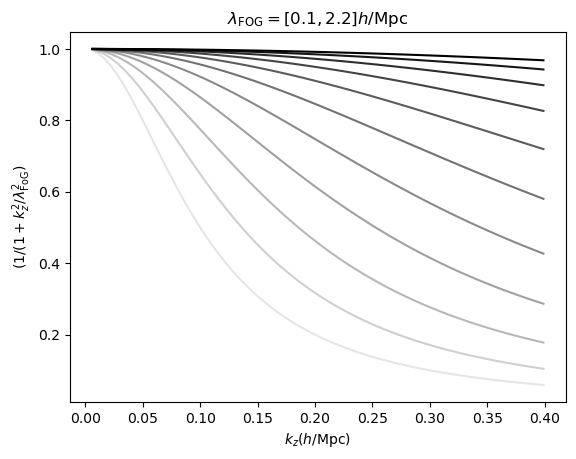

In [23]:
for i in range(len(lambda_FOGs)):
    
    plt.plot(kvals_z, damp(kvals_z, lambda_FOGs[i]), alpha = alpha[i], color = 'black')
    
plt.title('$\lambda_\mathrm{{FOG}}=[0.1,2.2] h/$Mpc'.format(lambda_FOG))
plt.xlabel('$k_z (h/$Mpc)')
plt.ylabel('$(1/(1+k_z^2/\lambda_{\mathrm{FoG}}^2)$')
plt.show()

### See impact on velocity dispersion $\sigma_v$

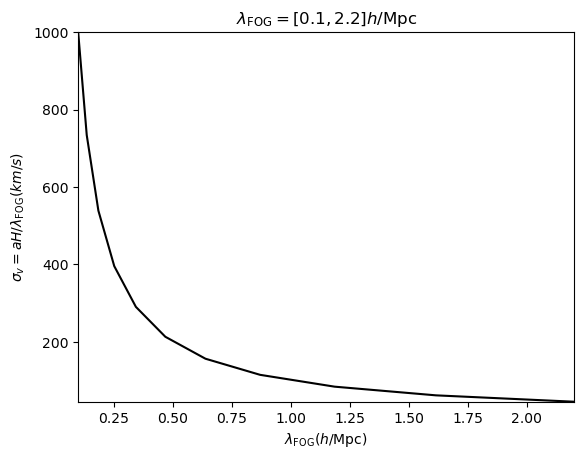

In [24]:
sigma_v = 100/lambda_FOGs # a = 1, H = H_0 = h100 km/s/Mpc, [sigma_v] = km/s
plt.plot(lambda_FOGs, sigma_v, color = 'black')
    
plt.title('$\lambda_\mathrm{{FOG}}=[0.1,2.2] h/$Mpc'.format(lambda_FOG))
plt.xlabel('$\lambda_\mathrm{FOG} (h/$Mpc)')
plt.ylabel('$\sigma_v=aH/\\lambda_\mathrm{FOG} (km/s)$')
plt.xlim(0.1,2.2)
plt.ylim(100/2.2,1000)
plt.show()

### See impact on relative velocities $v_z$

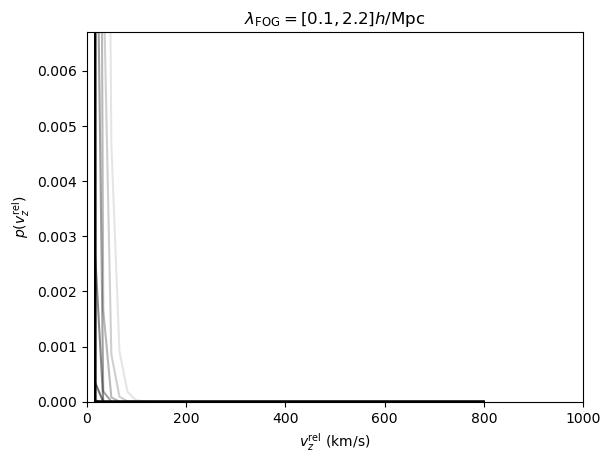

In [25]:
f_sat = 0.74
v_z = np.linspace(0, 800)
for i in range(len(lambda_FOGs)):
    p_v_z_1 = (1-f_sat)*signal.unit_impulse(len(v_z))
    p_v_z_2 = f_sat*np.exp(-lambda_FOGs[i]*v_z)
    plt.plot(v_z, p_v_z_2/np.sum(p_v_z_1+p_v_z_2), color = 'black', alpha = alpha[i])
    
plt.title('$\lambda_\mathrm{{FOG}}=[0.1,2.2] h/$Mpc'.format(lambda_FOG))
plt.xlabel('$v_z^\mathrm{rel}$ (km/s)')
plt.ylabel('$p(v_z^\mathrm{rel})$')
plt.xlim(0,1000)
plt.ylim(0, 0.0067)
plt.show()

## Plot the multipoles

In [26]:
def RSD_ell(tracer_field_eul_norm_zspace, tracer_field_eul_norm, ax0 = None, ax1 = None, f_sat = 0.7, lambda_FOG = 0.3, alpha = 1, i = 0, 
            plot = True, N = N, Lbox = Lbox, Nbox = Nbox, title = None, ell = 0, version = 0, xlim = (0, 0.63), ylabel = True, ax2 = None, ax3 = None,
            ax4 = None, ax5 = None, legend = True, norm = norm):
    
    # Start with large-scale RSDs
    RSD_large = tracer_field_eul_norm_zspace*(1-f_sat)
    if plot == True:
        plot_field(RSD_large, figsize=(6,6), title=r'$(1-f_s) \delta_{\mathrm{g}}(\vec{s}_c)$', plot = 'xz',
                   show_labels=False)
    
    # Now compute small-scale RSDs
    RSD_small = f_sat*ndimage.convolve1d(tracer_field_eul_norm_zspace, kernel_func(s_z_func(N), lambda_FOG), mode = 'wrap')
    if plot == True:
        plot_field(RSD_small, figsize=(6,6), title=r'$f_s \delta_{\mathrm{g}}(\vec{s}_c) *_z e^{(-\lambda_{\mathrm{FoG}} \mathrm{~s}_{\mathrm{z}})}$',
                   show_labels=False, plot = 'xz')
        
    # Add them together to get full RSDs
    delta_FOG = RSD_large+RSD_small
    if plot == True:
        plot_field(delta_FOG, figsize=(6,6), title=rf'$\delta_\mathrm{{tr}}^\mathrm{{FOG}}$, b={bias_params}', plot = 'xz',
                       show_labels=False)
        
    # Plot clustering
    def power_spectrum_err(ax0, ax1, tracer_field_eul_norm_zspace, label, color, l, ylabel, comm = MPI.COMM_WORLD, linestyle = '-', title = title, 
                           legend = legend): #sm
        
        def lin_pk_func(tracer_field_eul_norm_zspace, l):

            pm = pmesh.pm.ParticleMesh([Nbox, Nbox, Nbox], Lbox, dtype='float32', resampler='cic', comm=comm)

            # initialize a RealField
            gal_field = pmesh.pm.RealField(pm)
            gal_field[...] = tracer_field_eul_norm_zspace

            # Create the FFTPower objects
            lin_pk = FFTPower(gal_field.r2c(), '2d', kmin = 1e-5, kmax = 0.64, poles = [l])

            # k arrays are set like this
            kvals = lin_pk.poles['k'] # let's ignore the artificial zero k value

            return lin_pk.poles['power_'+str(l)].real*norm, kvals

        lin_pk_z, kvals_z = lin_pk_func(tracer_field_eul_norm_zspace, l)
        lin_pk_real, kvals_real = lin_pk_func(tracer_field_eul_norm, l)

        if (kvals_z!=kvals_real).any():
            raise TypeError("make sure the kvals are the same")

        # Plot the P(k)
        ax0.plot(kvals_z, kvals_z*lin_pk_z, linestyle = linestyle, label = label, alpha = alpha, color = color) # lin_pk.power['power'].real[1:]

        # Plot the ratio
        ax1.plot(kvals_z, lin_pk_z/lin_pk_real, linestyle = linestyle, label = label, alpha = alpha, color = color) # lin_pk.power['power'].real[1:]
        
        if i == 0:
            ax0.set_xlim(xlim)
            ax0.set_xticklabels([])
            ax0.set_title(title)
            # ax0.set_ylim(-4.25e-10, 9.75e-10)
            ax0.set_ylim(-2250, 4250)

            ax1.set_xlim(xlim)
            ax1.set_ylim(0.75, 1.2)
            ax1.set_xlabel('$k (h/$Mpc)')
            
            if (ylabel == True and version == 0 and alpha == 1) or (legend == True and version != 0 and alpha == 1) or (version == 2):
                ax0.legend()
                ax0.set_ylabel(r'$P^{\ell}(k)\times k $(Mpc$/h)^2$')
                ax1.set_ylabel('$P^{\ell}(k)_\mathrm{z}/P^{\ell}(k)_\mathrm{real}$')
            
        if (l != 0 and version == 0) or (legend == False and version == 1):
            ax0.set_yticklabels([])
            ax1.set_yticklabels([])
        
        return kvals_z
        
    if plot == True:
        
        fig = plt.figure()
        gs = gridspec.GridSpec(2, 1, height_ratios = [4,1])
        gs.update(hspace = 0)

        ax0 = fig.add_subplot(gs[0])
        ax1 = fig.add_subplot(gs[1])

    if version == 0:
        power_spectrum_err(ax0, ax1, delta_FOG, label = 'z-space (central distortion + FOG)', color = 'red', l = ell, ylabel = ylabel)
        power_spectrum_err(ax0, ax1, tracer_field_eul_norm_zspace, label = 'z-space (central distortion)', color = 'blue', l = ell, ylabel = ylabel)
        kvals_z = power_spectrum_err(ax0, ax1, tracer_field_eul_norm, label = 'real-space', color = 'green', l = ell, ylabel = ylabel)
        
    else:
        power_spectrum_err(ax0, ax1, delta_FOG, label = '$\ell=0$', color = 'purple', l = 0, ylabel = True, 
                           title = 'z-space (central distortion + FOG)', legend = False)
        power_spectrum_err(ax0, ax1, delta_FOG, label = '$\ell=2$', color = 'red', l = 2, ylabel = True, 
                           title = 'z-space (central distortion + FOG)', legend = None)
        kvals_z = power_spectrum_err(ax0, ax1, delta_FOG, label = '$\ell=4$', color = 'green', l = 4, ylabel = True, 
                                     title = 'z-space (central distortion + FOG)', legend = None)
        
        if version == 1:
            power_spectrum_err(ax2, ax3, tracer_field_eul_norm_zspace, label = '$\ell=0$', color = 'purple', l = 0, ylabel = ylabel, 
                               title = 'z-space (central distortion)', legend = False)
            power_spectrum_err(ax2, ax3, tracer_field_eul_norm_zspace, label = '$\ell=2$', color = 'red', l = 2, ylabel = ylabel, 
                               title = 'z-space (central distortion)', legend = None)
            power_spectrum_err(ax2, ax3, tracer_field_eul_norm_zspace, label = '$\ell=4$', color = 'green', l = 4, ylabel = ylabel, 
                               title = 'z-space (central distortion)', legend = None)

            power_spectrum_err(ax4, ax5, tracer_field_eul_norm, label = '$\ell=0$', color = 'purple', l = 0, ylabel = ylabel, title = 'real-space')
            power_spectrum_err(ax4, ax5, tracer_field_eul_norm, label = '$\ell=2$', color = 'red', l = 2, ylabel = ylabel, title = 'real-space')
            power_spectrum_err(ax4, ax5, tracer_field_eul_norm, label = '$\ell=4$', color = 'green', l = 4, ylabel = ylabel, title = 'real-space')
        
    return kvals_z

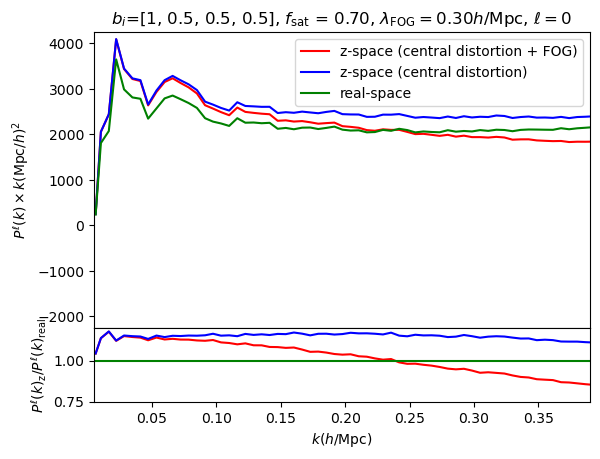

In [27]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios = [4,1])
gs.update(hspace = 0, wspace = 0)

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
xlim = (5e-3, 0.39)

RSD_ell(tracer_field_eul_norm_zspace, tracer_field_eul_norm, ax0, ax1, plot = plot, ell = 0, xlim = xlim,
        title = '$b_i$={:s}, $f_\mathrm{{sat}}$ = {:.2f}, $\lambda_\mathrm{{FOG}}={:.2f} h/$Mpc, $\ell=${:d}'.format(str(bias_params), 0.7, lambda_FOG, 0))
plt.show()

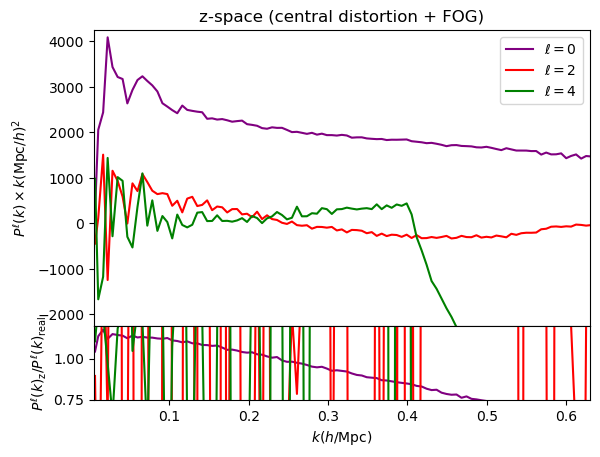

In [28]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios = [4,1])
gs.update(hspace = 0, wspace = 0)

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

RSD_ell(tracer_field_eul_norm_zspace, tracer_field_eul_norm, ax0, ax1, plot = plot, ell = 0, version = 2, xlim = (0.005, 0.63),
        title = '$b_i$={:s}, $f_\mathrm{{sat}}$ = {:.2f}, $\lambda_\mathrm{{FOG}}={:.2f} h/$Mpc, $\ell=${:d}'.format(str(bias_params), 0.7, lambda_FOG, 0))
plt.show()

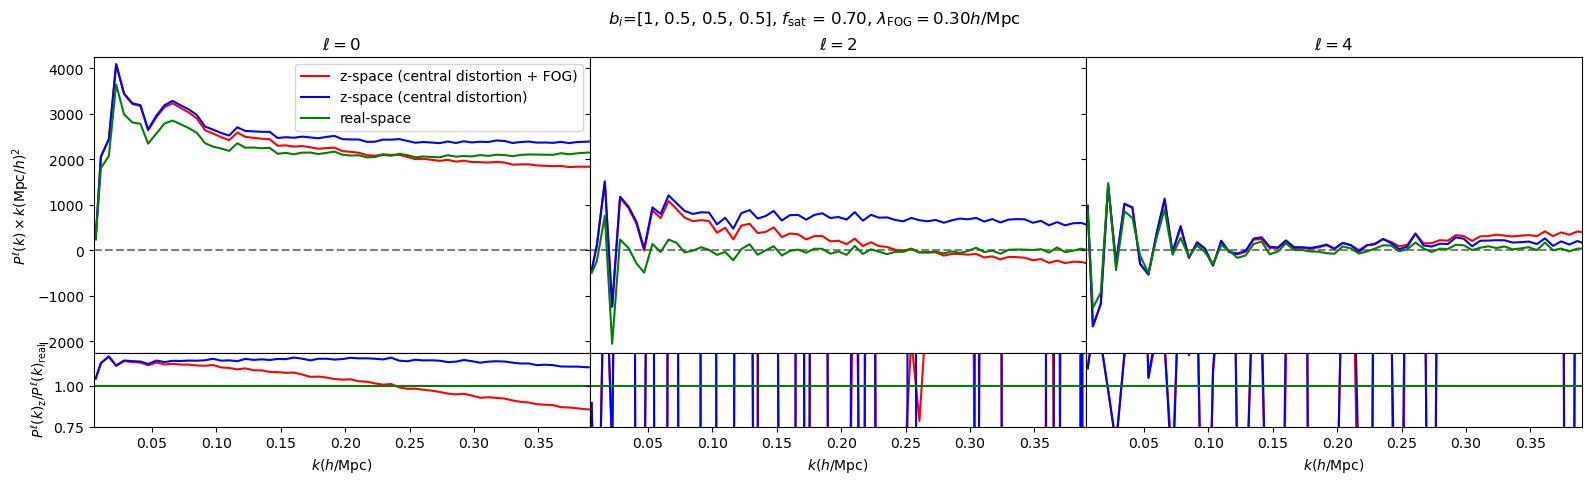

In [29]:
fig = plt.figure(figsize = (6.4*3, 4.8))
gs = gridspec.GridSpec(2, 3, height_ratios = [4,1])
gs.update(hspace = 0, wspace = 0)

ell = [0,2,4]
xlim = (5e-3, 0.39)
ylabel = [True, False, False]
for i in range(len(ell)):
    
    ax0 = fig.add_subplot(gs[i])
    ax1 = fig.add_subplot(gs[i+3])

    ax0.axhline(0e-10, linestyle = '--', color = 'black', alpha = 0.5)
    RSD_ell(tracer_field_eul_norm_zspace, tracer_field_eul_norm, ax0, ax1, plot = plot, ell = ell[i], ylabel = ylabel[i], xlim = xlim,
            title = '$\ell={:d}$'.format(ell[i]))
    
plt.suptitle('$b_i$={:s}, $f_\mathrm{{sat}}$ = {:.2f}, $\lambda_\mathrm{{FOG}}={:.2f} h/$Mpc'.format(str(bias_params), 0.7, lambda_FOG))
plt.show()

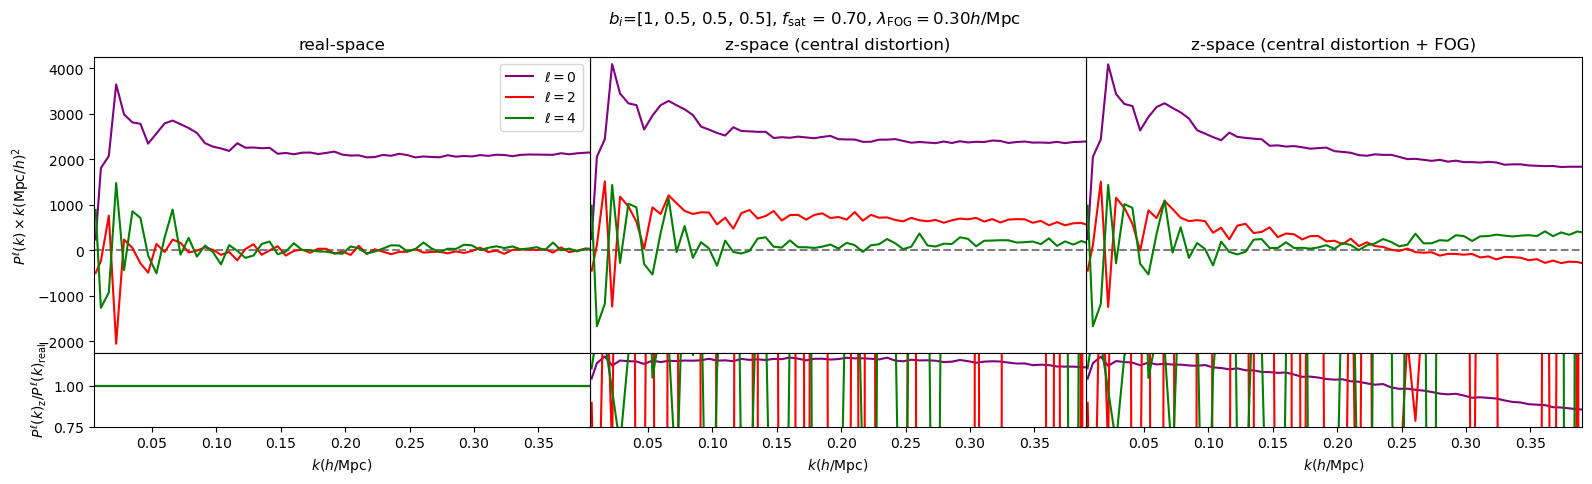

In [30]:
fig = plt.figure(figsize = (6.4*3, 4.8))
gs = gridspec.GridSpec(2, 3, height_ratios = [4,1])
gs.update(hspace = 0, wspace = 0)

ell = [0,2,4]
title = ['real-space', 'z-space (central distortion)', 'z-space (central distortion + FOG)']
# for i in range(len(ell)):
    
ax0 = fig.add_subplot(gs[2])
ax1 = fig.add_subplot(gs[5])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[4])
ax4 = fig.add_subplot(gs[0])
ax5 = fig.add_subplot(gs[3])

ax0.axhline(0e-10, linestyle = '--', color = 'black', alpha = 0.5)
ax2.axhline(0e-10, linestyle = '--', color = 'black', alpha = 0.5)
ax4.axhline(0e-10, linestyle = '--', color = 'black', alpha = 0.5)
RSD_ell(tracer_field_eul_norm_zspace, tracer_field_eul_norm, ax0, ax1, plot = plot, version = 1, ax2 = ax2, ax3 = ax3, ax4 = ax4, xlim = xlim,
        ax5 = ax5)

plt.suptitle('$b_i$={:s}, $f_\mathrm{{sat}}$ = {:.2f}, $\lambda_\mathrm{{FOG}}={:.2f} h/$Mpc'.format(str(bias_params), 0.7, lambda_FOG))
plt.show()

### See the impact of $f_\mathrm{sat}$

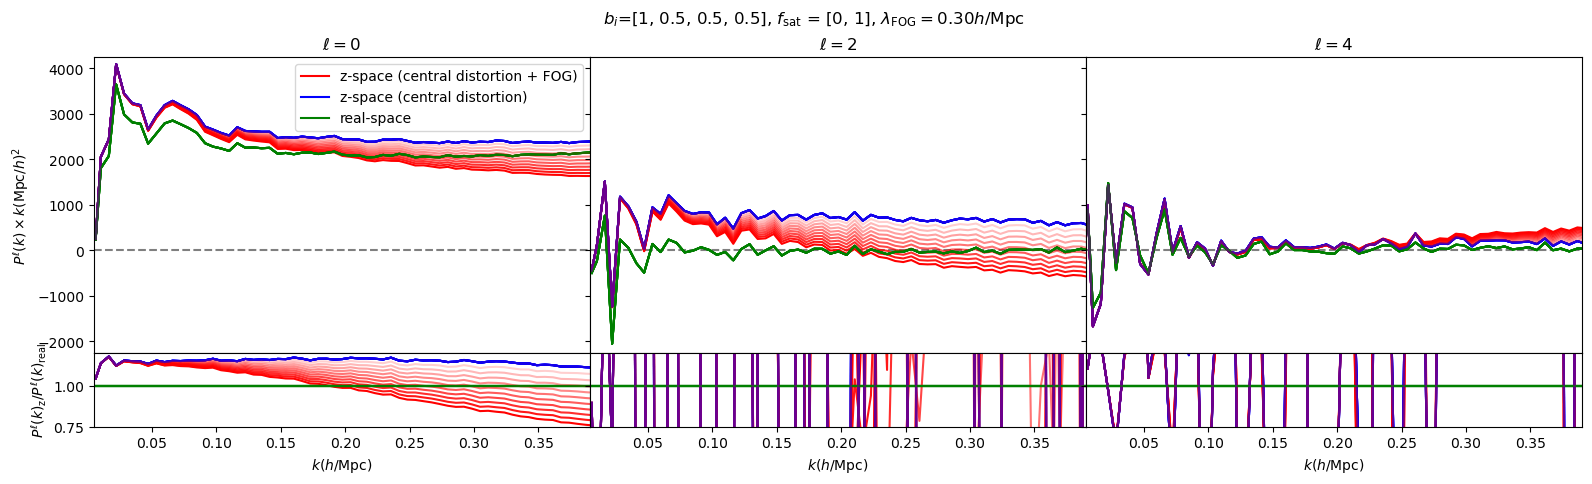

In [31]:
fig = plt.figure(figsize = (6.4*3, 4.8))
gs = gridspec.GridSpec(2, 3, height_ratios = [4,1])
gs.update(hspace = 0, wspace = 0)

ell = [0,2,4]
xlim = (5e-3, 0.39)
ylabel = [True, False, False]

alpha =  np.linspace(1,0.1,11)
for i in range(len(ell)):

    ax0 = fig.add_subplot(gs[i])
    ax1 = fig.add_subplot(gs[i+3])

    ax0.axhline(0e-10, linestyle = '--', color = 'black', alpha = 0.5)
    
    for j in range(len(f_sats)):
        RSD_ell(tracer_field_eul_norm_zspace, tracer_field_eul_norm, ax0, ax1, plot = plot, ell = ell[i], ylabel = ylabel[i], xlim = xlim,
                title = '$\ell={:d}$'.format(ell[i]), f_sat = f_sats[j], alpha = alpha[j])
    
plt.suptitle('$b_i$={:s}, $f_\mathrm{{sat}}$ = [0, 1], $\lambda_\mathrm{{FOG}}={:.2f} h/$Mpc'.format(str(bias_params), lambda_FOG))
plt.show()

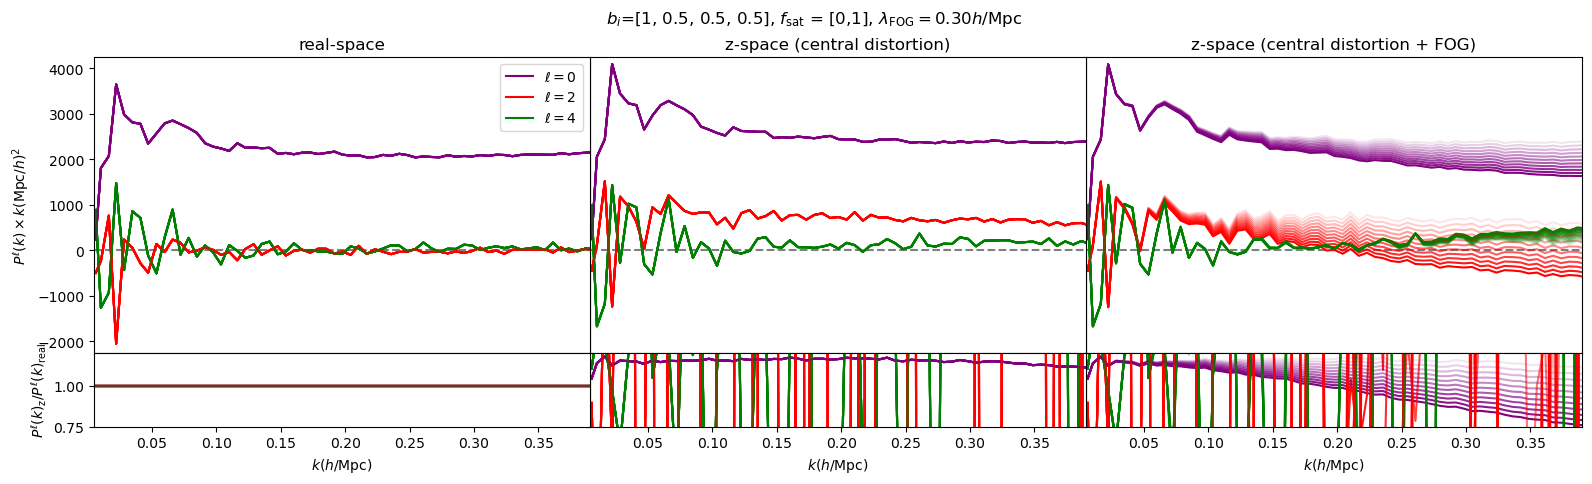

In [32]:
fig = plt.figure(figsize = (6.4*3, 4.8))
gs = gridspec.GridSpec(2, 3, height_ratios = [4,1])
gs.update(hspace = 0, wspace = 0)

ell = [0,2,4]
title = ['real-space', 'z-space (central distortion)', 'z-space (central distortion + FOG)']
    
ax0 = fig.add_subplot(gs[2])
ax1 = fig.add_subplot(gs[5])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[4])
ax4 = fig.add_subplot(gs[0])
ax5 = fig.add_subplot(gs[3])

ax0.axhline(0e-10, linestyle = '--', color = 'black', alpha = 0.5)
ax2.axhline(0e-10, linestyle = '--', color = 'black', alpha = 0.5)
ax4.axhline(0e-10, linestyle = '--', color = 'black', alpha = 0.5)

for j in range(len(f_sats)):
    RSD_ell(tracer_field_eul_norm_zspace, tracer_field_eul_norm, ax0, ax1, plot = plot, version = 1, ax2 = ax2, ax3 = ax3, ax4 = ax4, xlim = xlim,
            ax5 = ax5, f_sat = f_sats[j], alpha = alpha[j])

plt.suptitle('$b_i$={:s}, $f_\mathrm{{sat}}$ = [0,1], $\lambda_\mathrm{{FOG}}={:.2f} h/$Mpc'.format(str(bias_params), lambda_FOG))
plt.show()

### See the impact of $\lambda_\mathrm{FOG}$

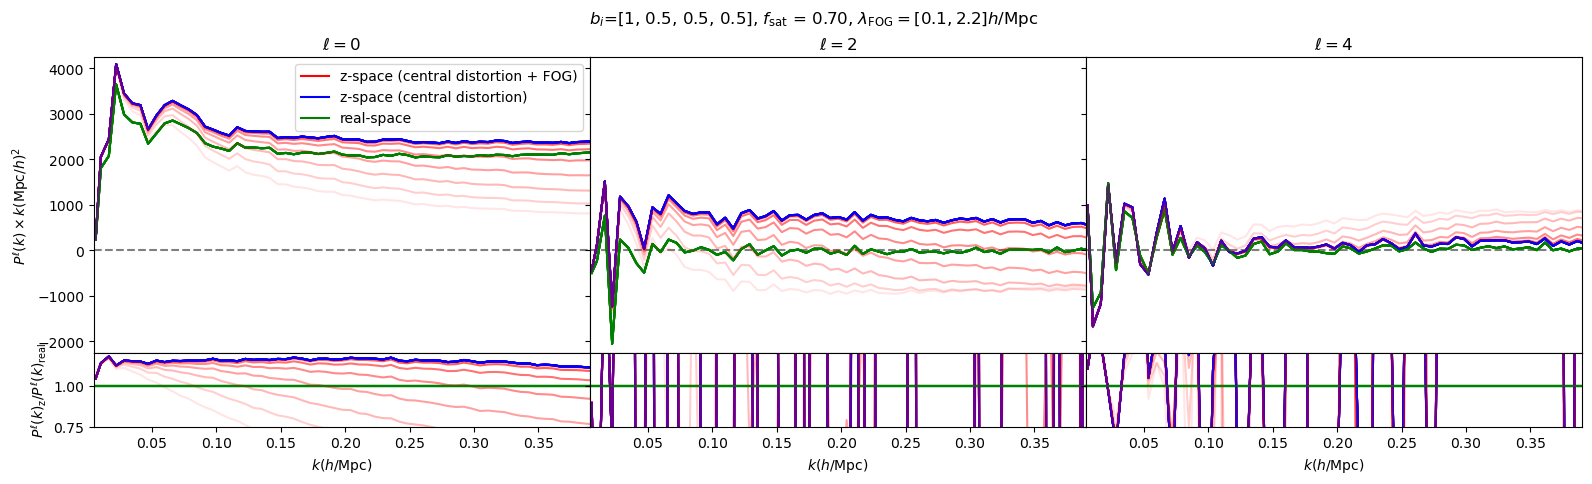

In [33]:
fig = plt.figure(figsize = (6.4*3, 4.8))
gs = gridspec.GridSpec(2, 3, height_ratios = [4,1])
gs.update(hspace = 0, wspace = 0)

ell = [0,2,4]
xlim = (5e-3, 0.39)
ylabel = [True, False, False]

for i in range(len(ell)):

    ax0 = fig.add_subplot(gs[i])
    ax1 = fig.add_subplot(gs[i+3])

    ax0.axhline(0e-10, linestyle = '--', color = 'black', alpha = 0.5)
    
    for j in range(len(lambda_FOGs)):
        RSD_ell(tracer_field_eul_norm_zspace, tracer_field_eul_norm, ax0, ax1, plot = plot, ell = ell[i], ylabel = ylabel[i], xlim = xlim,
                title = '$\ell={:d}$'.format(ell[i]), lambda_FOG = lambda_FOGs[j], alpha = alpha[j])
    
plt.suptitle('$b_i$={:s}, $f_\mathrm{{sat}}$ = {:.2f}, $\lambda_\mathrm{{FOG}}=[0.1, 2.2] h/$Mpc'.format(str(bias_params), 0.7))
plt.show()

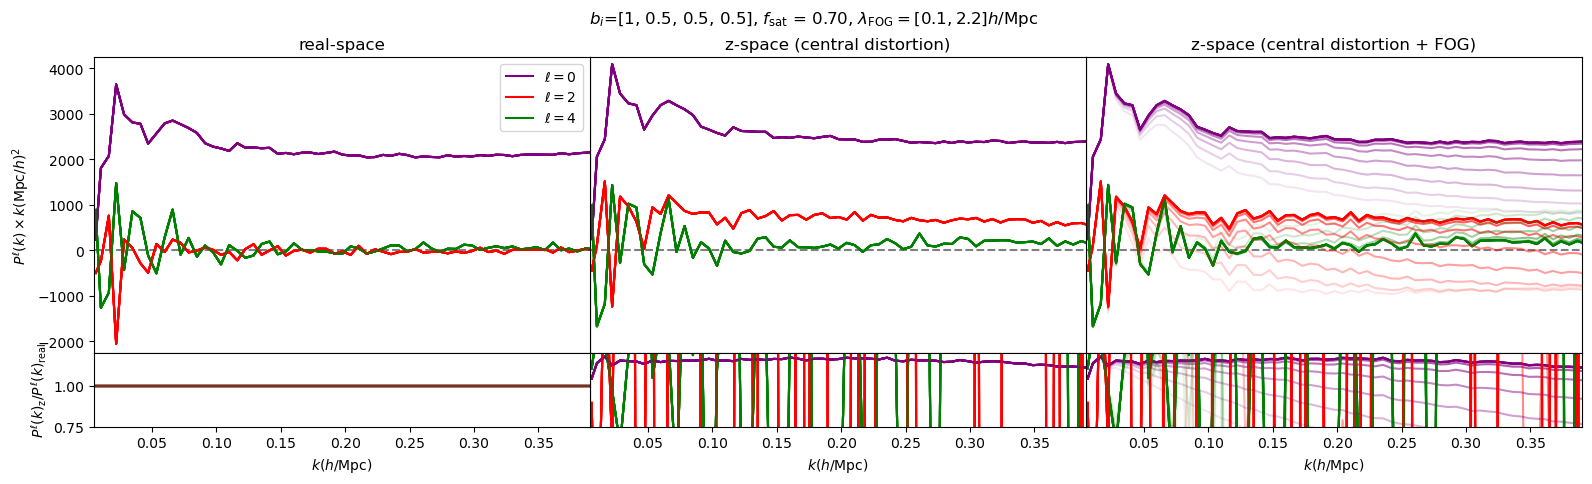

In [34]:
fig = plt.figure(figsize = (6.4*3, 4.8))
gs = gridspec.GridSpec(2, 3, height_ratios = [4,1])
gs.update(hspace = 0, wspace = 0)

ell = [0,2,4]
title = ['real-space', 'z-space (central distortion)', 'z-space (central distortion + FOG)']
    
ax0 = fig.add_subplot(gs[2])
ax1 = fig.add_subplot(gs[5])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[4])
ax4 = fig.add_subplot(gs[0])
ax5 = fig.add_subplot(gs[3])

ax0.axhline(0e-10, linestyle = '--', color = 'black', alpha = 0.5)
ax2.axhline(0e-10, linestyle = '--', color = 'black', alpha = 0.5)
ax4.axhline(0e-10, linestyle = '--', color = 'black', alpha = 0.5)

for i in range(len(lambda_FOGs)):
    RSD_ell(tracer_field_eul_norm_zspace, tracer_field_eul_norm, ax0, ax1, plot = plot, version = 1, ax2 = ax2, ax3 = ax3, ax4 = ax4, xlim = xlim,
            ax5 = ax5, lambda_FOG = lambda_FOGs[i], alpha = alpha[i])

plt.suptitle('$b_i$={:s}, $f_\mathrm{{sat}}$ = {:.2f}, $\lambda_\mathrm{{FOG}}=[0.1,2.2] h/$Mpc'.format(str(bias_params), 0.7))
plt.show()

## Compare to theory
### $P_{\mathrm{tr}}^{\mathrm{FoG}}(k, \mu)=P_{\mathrm{tr}}(k, \mu)\left(\left(1-f_{\mathrm{sat}}\right)+f_{\mathrm{sat}} \frac{\lambda_{\mathrm{FoG}}^2}{\lambda_{\mathrm{FoG}}^2+k^2 \mu^2}\right)^2$

In [35]:
def RSD_theory(lin_pk, f_sat = 0.7, lambda_FOG = 0.3):
    
    return np.nanmean(lin_pk.power['power']*(1-f_sat+f_sat*damp(lin_pk.power['k']*lin_pk.power['mu'], lambda_FOG))**2, axis = 1)*norm

/home/groups/tabel/mahlet/nbody-env/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


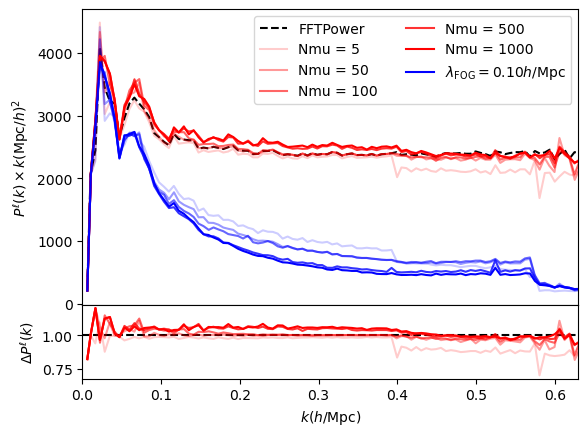

In [36]:
l = 0
lambda_FOG = 0.1
pm = pmesh.pm.ParticleMesh([Nbox, Nbox, Nbox], Lbox, dtype='float32', resampler='cic', comm=MPI.COMM_WORLD)

# initialize a RealField
gal_field = pmesh.pm.RealField(pm)
gal_field[...] = tracer_field_eul_norm_zspace

fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios = [4,1])
gs.update(hspace = 0, wspace = 0)

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

# Create the FFTPower objects
Nmu = 5
lin_pk_fid = FFTPower(gal_field.r2c(), '2d', kmin = 1e-5, kmax = 0.64, poles = [l], Nmu = Nmu)

# k arrays are set like this
kvals = lin_pk_fid.poles['k'] # let's ignore the artificial zero k value

# Plot the P(k)
lin_pk_fid_power = lin_pk_fid.poles['power_'+str(l)].real*norm
ax0.plot(kvals, kvals*lin_pk_fid_power, label = 'FFTPower', color = 'black', linestyle = '--') # lin_pk.power['power'].real[1:]
ax1.axhline(1, color = 'black', linestyle = '--')

for Nmu, alpha in zip([5, 50, 100, 500, 1000], [0.2, 0.4, 0.6, 0.8, 1]):
    lin_pk = FFTPower(gal_field.r2c(), '2d', kmin = 1e-5, kmax = 0.64, poles = [l], Nmu = Nmu)

    # try computing P(k) from P(k, mu)
    P_k = lin_pk.power.average('mu')
    ax0.plot(P_k['k'], P_k['k']*P_k['power']*norm, label = 'Nmu = '+str(Nmu), color = 'red', alpha = alpha)
    ax1.plot(P_k['k'], P_k['k']*P_k['power']*norm/(kvals*lin_pk_fid_power), color = 'red', alpha = alpha)
    
    theory = RSD_theory(lin_pk, f_sat = 0.74, lambda_FOG = lambda_FOG)
    if Nmu == 1000:
        ax0.plot(P_k['k'], P_k['k']*theory, label = '$\lambda_\mathrm{{FOG}}={:.2f}h$/Mpc'.format(lambda_FOG), color = 'blue', alpha = alpha)
    else:
        ax0.plot(P_k['k'], P_k['k']*theory, color = 'blue', alpha = alpha)

ax0.legend(ncol = 2)
ax0.set_ylabel(r'$P^{\ell}(k)\times k $(Mpc$/h)^2$')
ax0.set_xlim(0, 0.63)
ax0.set_xticks([])

ax1.set_xlabel('$k (h/$Mpc)')
ax1.set_ylabel(r'$\Delta P^{\ell}(k)$')
ax1.set_xlim(0, 0.63)
plt.show()

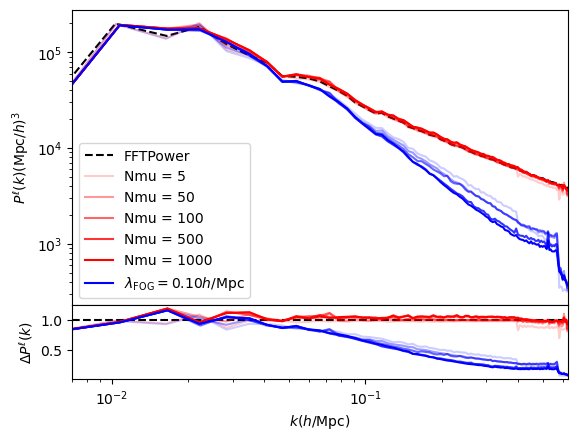

In [37]:
l = 0
pm = pmesh.pm.ParticleMesh([Nbox, Nbox, Nbox], Lbox, dtype='float32', resampler='cic', comm=MPI.COMM_WORLD)

# initialize a RealField
gal_field = pmesh.pm.RealField(pm)
gal_field[...] = tracer_field_eul_norm_zspace

fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios = [4,1])
gs.update(hspace = 0, wspace = 0)

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

# Create the FFTPower objects
Nmu = 5
lin_pk_fid = FFTPower(gal_field.r2c(), '2d', kmin = 1e-5, kmax = 0.64, poles = [l], Nmu = Nmu)

# k arrays are set like this
kvals = lin_pk_fid.poles['k'] # let's ignore the artificial zero k value

# Plot the P(k)
lin_pk_fid_power = lin_pk_fid.poles['power_'+str(l)].real*norm
ax0.plot(kvals, lin_pk_fid_power, label = 'FFTPower', color = 'black', linestyle = '--') # lin_pk.power['power'].real[1:]
ax1.axhline(1, color = 'black', linestyle = '--')

for Nmu, alpha in zip([5, 50, 100, 500, 1000], [0.2, 0.4, 0.6, 0.8, 1]):
    lin_pk = FFTPower(gal_field.r2c(), '2d', kmin = 1e-5, kmax = 0.64, poles = [l], Nmu = Nmu)

    # try computing P(k) from P(k, mu)
    P_k = lin_pk.power.average('mu')
    ax0.loglog(P_k['k'], P_k['power']*norm, label = 'Nmu = '+str(Nmu), color = 'red', alpha = alpha)
    ax1.plot(P_k['k'], P_k['power']*norm/lin_pk_fid_power, color = 'red', alpha = alpha)
    
    theory = RSD_theory(lin_pk, f_sat = 0.74, lambda_FOG = lambda_FOG)
    if Nmu == 1000:
        ax0.loglog(P_k['k'], theory, label = '$\lambda_\mathrm{{FOG}}={:.2f}h$/Mpc'.format(lambda_FOG), color = 'blue', alpha = alpha)
    else:
        ax0.loglog(P_k['k'], theory, color = 'blue', alpha = alpha)
    ax1.plot(P_k['k'], theory/lin_pk_fid_power, color = 'blue', alpha = alpha)

ax0.legend()
ax0.set_ylabel(r'$P^{\ell}(k) $(Mpc$/h)^3$')
ax0.set_xlim(7e-3, 0.63)
ax0.set_xticks([])

ax1.set_xlabel('$k (h/$Mpc)')
ax1.set_ylabel(r'$\Delta P^{\ell}(k)$')
ax1.set_xlim(7e-3, 0.63)
ax1.set_xscale('log')
plt.show()

In [38]:
def plot_Pk(tracer_field_eul_norm_zspace, ax0, ax1, color, l = 0, Nmu = 5, Nbox = Nbox, Lbox = Lbox, comm = MPI.COMM_WORLD, alpha = 1, label = None):
    
    pm = pmesh.pm.ParticleMesh([Nbox, Nbox, Nbox], Lbox, dtype='float32', resampler='cic', comm=comm)

    # initialize a RealField
    gal_field = pmesh.pm.RealField(pm)
    gal_field[...] = tracer_field_eul_norm_zspace

    # Create the FFTPower objects
    lin_pk_fid = FFTPower(gal_field.r2c(), '2d', kmin = 1e-5, kmax = 0.64, poles = [l], Nmu = Nmu)

    # k arrays are set like this
    kvals = lin_pk_fid.poles['k'] # let's ignore the artificial zero k value

    # Plot the P(k)
    lin_pk_fid_power = lin_pk_fid.poles['power_'+str(l)].real*norm
    ax0.plot(kvals, lin_pk_fid_power, label = label, color = color, linestyle = '--', alpha = alpha) # lin_pk.power['power'].real[1:]
    
    return kvals, lin_pk_fid_power

def delta_FOG_func(tracer_field_eul_norm_zspace, f_sat = 0.7, lambda_FOG = 0.3, N = N):
    
    # Start with large-scale RSDs
    RSD_large = tracer_field_eul_norm_zspace*(1-f_sat)

    # Now compute small-scale RSDs
    RSD_small = f_sat*ndimage.convolve1d(tracer_field_eul_norm_zspace, kernel_func(s_z_func(N), lambda_FOG), mode = 'wrap')

    # Add them together to get full RSDs
    return RSD_large+RSD_small

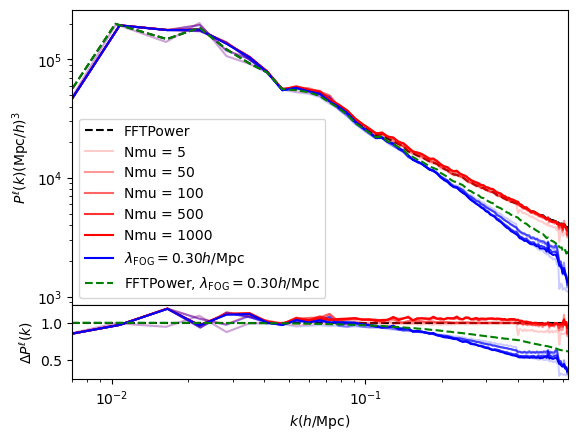

In [39]:
f_sat = 0.7
f_sat_theory = 0.7
lambda_FOG = 0.3
lambda_FOG_theory = 0.3

fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios = [4,1])
gs.update(hspace = 0, wspace = 0)

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

kvals, lin_pk_fid_power = plot_Pk(tracer_field_eul_norm_zspace, ax0, ax1, color = 'black', label = 'FFTPower')
ax1.axhline(1, color = 'black', linestyle = '--')

for Nmu, alpha in zip([5, 50, 100, 500, 1000], [0.2, 0.4, 0.6, 0.8, 1]):
    lin_pk = FFTPower(gal_field.r2c(), '2d', kmin = 1e-5, kmax = 0.64, poles = [l], Nmu = Nmu)

    # try computing P(k) from P(k, mu)
    P_k = lin_pk.power.average('mu')
    ax0.loglog(P_k['k'], P_k['power']*norm, label = 'Nmu = '+str(Nmu), color = 'red', alpha = alpha)
    ax1.plot(P_k['k'], P_k['power']*norm/lin_pk_fid_power, color = 'red', alpha = alpha)
    
    theory = RSD_theory(lin_pk, f_sat = f_sat_theory, lambda_FOG = lambda_FOG_theory)
    if Nmu == 1000:
        ax0.loglog(P_k['k'], theory, label = '$\lambda_\mathrm{{FOG}}={:.2f}h$/Mpc'.format(lambda_FOG_theory), color = 'blue', alpha = alpha)
    else:
        ax0.loglog(P_k['k'], theory, color = 'blue', alpha = alpha)
    ax1.plot(P_k['k'], theory/lin_pk_fid_power, color = 'blue', alpha = alpha)

# Add them together to get full RSDs
kvals, lin_pk_RSD_power = plot_Pk(delta_FOG_func(tracer_field_eul_norm_zspace, f_sat = f_sat, lambda_FOG = lambda_FOG), ax0, ax1, color = 'green', 
                                  label = 'FFTPower, $\lambda_\mathrm{{FOG}}={:.2f}h$/Mpc'.format(lambda_FOG))
ax1.plot(kvals, lin_pk_RSD_power/lin_pk_fid_power, color = 'green', linestyle = '--')

ax0.legend()
ax0.set_ylabel(r'$P^{\ell}(k) $(Mpc$/h)^3$')
ax0.set_xlim(7e-3, 0.63)
ax0.set_xticks([])

ax1.set_xlabel('$k (h/$Mpc)')
ax1.set_ylabel(r'$\Delta P^{\ell}(k)$')
ax1.set_xlim(7e-3, 0.63)
ax1.set_xscale('log')
plt.show()

### Try a different fit

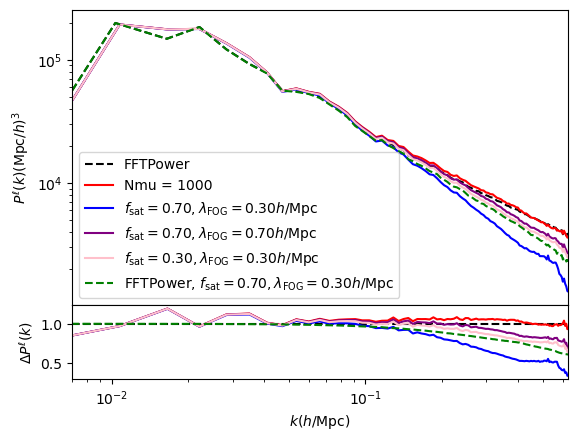

In [40]:
f_sat = 0.7
f_sat_theory = 0.7
lambda_FOG = 0.3
lambda_FOG_theory = 0.3

fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios = [4,1])
gs.update(hspace = 0, wspace = 0)

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

kvals, lin_pk_fid_power = plot_Pk(tracer_field_eul_norm_zspace, ax0, ax1, color = 'black', label = 'FFTPower')
ax1.axhline(1, color = 'black', linestyle = '--')

lin_pk = FFTPower(gal_field.r2c(), '2d', kmin = 1e-5, kmax = 0.64, poles = [l], Nmu = Nmu)

# try computing P(k) from P(k, mu)
P_k = lin_pk.power.average('mu')
ax0.loglog(P_k['k'], P_k['power']*norm, label = 'Nmu = '+str(Nmu), color = 'red', alpha = alpha)
ax1.plot(P_k['k'], P_k['power']*norm/lin_pk_fid_power, color = 'red', alpha = alpha)

# try different fits
for f_sat_theory, lambda_FOG_theory, color in zip([0.7, 0.7, 0.3], [0.3, 0.7, 0.3], ['blue', 'purple', 'pink']):
    theory = RSD_theory(lin_pk, f_sat = f_sat_theory, lambda_FOG = lambda_FOG_theory)
    ax0.loglog(P_k['k'], theory, label = '$f_\mathrm{{sat}}={:.2f}, \lambda_\mathrm{{FOG}}={:.2f}h$/Mpc'.format(f_sat_theory, lambda_FOG_theory), 
               color = color)
    ax1.plot(P_k['k'], theory/lin_pk_fid_power, color = color)

# Add them together to get full RSDs
kvals, lin_pk_RSD_power = plot_Pk(delta_FOG_func(tracer_field_eul_norm_zspace, f_sat = f_sat, lambda_FOG = lambda_FOG), ax0, ax1, color = 'green', 
                                  label = 'FFTPower, $f_\mathrm{{sat}}={:.2f}, \lambda_\mathrm{{FOG}}={:.2f}h$/Mpc'.format(f_sat, lambda_FOG))
ax1.plot(kvals, lin_pk_RSD_power/lin_pk_fid_power, color = 'green', linestyle = '--')

ax0.legend()
ax0.set_ylabel(r'$P^{\ell}(k) $(Mpc$/h)^3$')
ax0.set_xlim(7e-3, 0.63)
ax0.set_xticks([])

ax1.set_xlabel('$k (h/$Mpc)')
ax1.set_ylabel(r'$\Delta P^{\ell}(k)$')
ax1.set_xlim(7e-3, 0.63)
ax1.set_xscale('log')
plt.show()

### See the impact of $f_\mathrm{sat}$

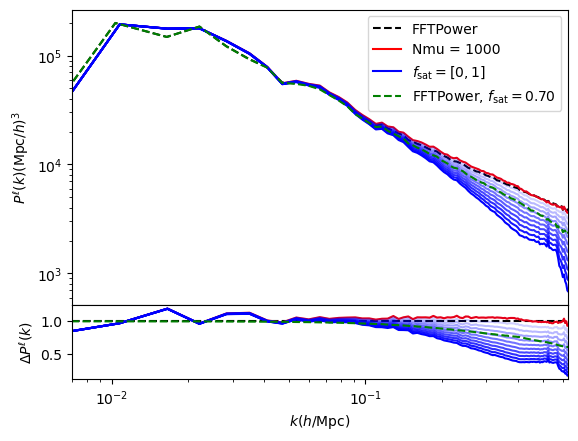

In [41]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios = [4,1])
gs.update(hspace = 0, wspace = 0)

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

kvals, lin_pk_fid_power = plot_Pk(tracer_field_eul_norm_zspace, ax0, ax1, color = 'black', label = 'FFTPower')
ax1.axhline(1, color = 'black', linestyle = '--')

lin_pk = FFTPower(gal_field.r2c(), '2d', kmin = 1e-5, kmax = 0.64, poles = [l], Nmu = Nmu)

# try computing P(k) from P(k, mu)
P_k = lin_pk.power.average('mu')
ax0.loglog(P_k['k'], P_k['power']*norm, label = 'Nmu = '+str(Nmu), color = 'red')
ax1.plot(P_k['k'], P_k['power']*norm/lin_pk_fid_power, color = 'red')
    
alpha =  np.linspace(1,0.1,11)
for i in range(len(f_sats)):
    theory = RSD_theory(lin_pk, f_sat = f_sats[i])
    if f_sats[i] == 1:
        ax0.loglog(P_k['k'], theory, label = '$f_\mathrm{{sat}}=[0, 1]$', color = 'blue')
    else:
        ax0.loglog(P_k['k'], theory, color = 'blue', alpha = alpha[i])
    ax1.plot(P_k['k'], theory/lin_pk_fid_power, color = 'blue', alpha = alpha[i])

# Add them together to get full RSDs
kvals, lin_pk_RSD_power = plot_Pk(delta_FOG_func(tracer_field_eul_norm_zspace), ax0, ax1, color = 'green', 
                                  label = 'FFTPower, $f_\mathrm{{sat}}={:.2f}$'.format(f_sat))
ax1.plot(kvals, lin_pk_RSD_power/lin_pk_fid_power, color = 'green', linestyle = '--')

ax0.legend()
ax0.set_ylabel(r'$P^{\ell}(k) $(Mpc$/h)^3$')
ax0.set_xlim(7e-3, 0.63)
ax0.set_xticks([])
# ax0.set_ylim(5.5e-11,6.25e-8)

ax1.set_xlabel('$k (h/$Mpc)')
ax1.set_ylabel(r'$\Delta P^{\ell}(k)$')
ax1.set_xlim(7e-3, 0.63)
ax1.set_xscale('log')
plt.show()

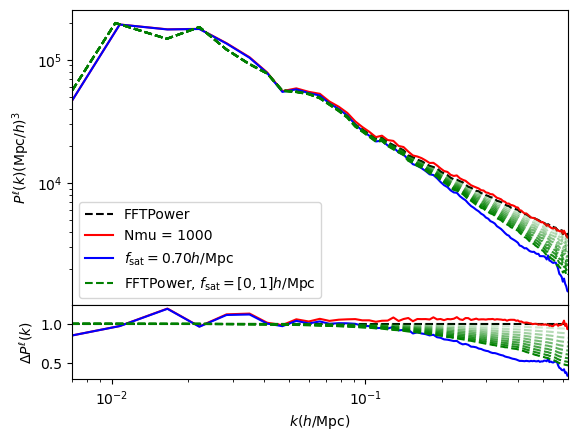

In [42]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios = [4,1])
gs.update(hspace = 0, wspace = 0)

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

kvals, lin_pk_fid_power = plot_Pk(tracer_field_eul_norm_zspace, ax0, ax1, color = 'black', label = 'FFTPower')
ax1.axhline(1, color = 'black', linestyle = '--')

lin_pk = FFTPower(gal_field.r2c(), '2d', kmin = 1e-5, kmax = 0.64, poles = [l], Nmu = Nmu)

# try computing P(k) from P(k, mu)
P_k = lin_pk.power.average('mu')
ax0.loglog(P_k['k'], P_k['power']*norm, label = 'Nmu = '+str(Nmu), color = 'red')
ax1.plot(P_k['k'], P_k['power']*norm/lin_pk_fid_power, color = 'red')
    
theory = RSD_theory(lin_pk)
ax0.loglog(P_k['k'], theory, label = '$f_\mathrm{{sat}}={:.2f}h$/Mpc'.format(0.7), color = 'blue')
ax1.plot(P_k['k'], theory/lin_pk_fid_power, color = 'blue')

# Add them together to get full RSDs
alpha =  np.linspace(1,0.1,11)
for i in range(len(f_sats)):
    delta_FOG = delta_FOG_func(tracer_field_eul_norm_zspace, f_sat = f_sats[i])
    if f_sats[i] == 1:
        kvals, lin_pk_RSD_power = plot_Pk(delta_FOG, ax0, ax1, color = 'green', 
                                      label = 'FFTPower, $f_\mathrm{{sat}}=[0, 1]h$/Mpc', alpha = alpha[i])
    else:
        kvals, lin_pk_RSD_power = plot_Pk(delta_FOG, ax0, ax1, color = 'green', 
                                          alpha = alpha[i])
    ax1.plot(kvals, lin_pk_RSD_power/lin_pk_fid_power, color = 'green', linestyle = '--', alpha = alpha[i])

ax0.legend()
ax0.set_ylabel(r'$P^{\ell}(k) $(Mpc$/h)^3$')
ax0.set_xlim(7e-3, 0.63)
ax0.set_xticks([])
# ax0.set_ylim(5.5e-11,6.25e-8)

ax1.set_xlabel('$k (h/$Mpc)')
ax1.set_ylabel(r'$\Delta P^{\ell}(k)$')
ax1.set_xlim(7e-3, 0.63)
ax1.set_xscale('log')
plt.show()

### See the impact of $\lambda_\mathrm{FOG}$

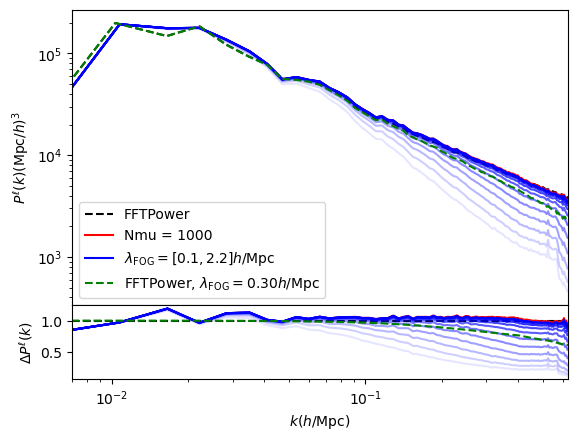

In [43]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios = [4,1])
gs.update(hspace = 0, wspace = 0)

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

kvals, lin_pk_fid_power = plot_Pk(tracer_field_eul_norm_zspace, ax0, ax1, color = 'black', label = 'FFTPower')
ax1.axhline(1, color = 'black', linestyle = '--')

lin_pk = FFTPower(gal_field.r2c(), '2d', kmin = 1e-5, kmax = 0.64, poles = [l], Nmu = Nmu)

# try computing P(k) from P(k, mu)
P_k = lin_pk.power.average('mu')
ax0.loglog(P_k['k'], P_k['power']*norm, label = 'Nmu = '+str(Nmu), color = 'red')
ax1.plot(P_k['k'], P_k['power']*norm/lin_pk_fid_power, color = 'red')
    
for i in range(len(lambda_FOGs)):
    theory = RSD_theory(lin_pk, lambda_FOG = lambda_FOGs[i])
    if i == 0:
        ax0.loglog(P_k['k'], theory, label = '$\lambda_\mathrm{{FOG}}=[0.1, 2.2]h$/Mpc', color = 'blue', alpha = alpha[i])
    else:
        ax0.loglog(P_k['k'], theory, color = 'blue', alpha = alpha[i])
    ax1.plot(P_k['k'], theory/lin_pk_fid_power, color = 'blue', alpha = alpha[i])

# Add them together to get full RSDs
kvals, lin_pk_RSD_power = plot_Pk(delta_FOG_func(tracer_field_eul_norm_zspace), ax0, ax1, color = 'green', 
                                  label = 'FFTPower, $\lambda_\mathrm{{FOG}}={:.2f}h$/Mpc'.format(0.3))
ax1.plot(kvals, lin_pk_RSD_power/lin_pk_fid_power, color = 'green', linestyle = '--')

ax0.legend()
ax0.set_ylabel(r'$P^{\ell}(k) $(Mpc$/h)^3$')
ax0.set_xlim(7e-3, 0.63)
ax0.set_xticks([])

ax1.set_xlabel('$k (h/$Mpc)')
ax1.set_ylabel(r'$\Delta P^{\ell}(k)$')
ax1.set_xlim(7e-3, 0.63)
ax1.set_xscale('log')
plt.show()

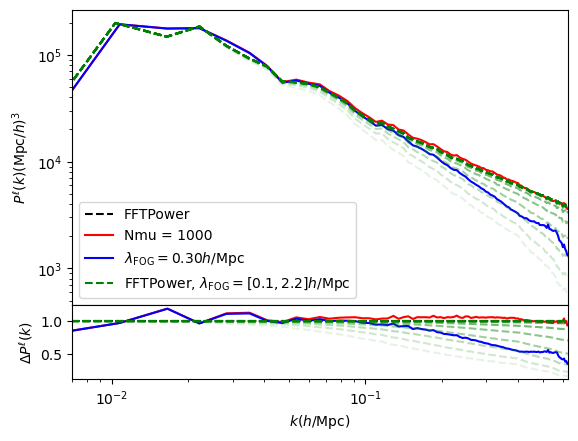

In [44]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios = [4,1])
gs.update(hspace = 0, wspace = 0)

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

kvals, lin_pk_fid_power = plot_Pk(tracer_field_eul_norm_zspace, ax0, ax1, color = 'black', label = 'FFTPower')
ax1.axhline(1, color = 'black', linestyle = '--')

# for Nmu, alpha in zip([5, 50, 100, 500, 1000], [0.2, 0.4, 0.6, 0.8, 1]):
lin_pk = FFTPower(gal_field.r2c(), '2d', kmin = 1e-5, kmax = 0.64, poles = [l], Nmu = Nmu)

# try computing P(k) from P(k, mu)
P_k = lin_pk.power.average('mu')
ax0.loglog(P_k['k'], P_k['power']*norm, label = 'Nmu = '+str(Nmu), color = 'red')
ax1.plot(P_k['k'], P_k['power']*norm/lin_pk_fid_power, color = 'red')
    
theory = RSD_theory(lin_pk)
ax0.loglog(P_k['k'], theory, label = '$\lambda_\mathrm{{FOG}}={:.2f}h$/Mpc'.format(0.3), color = 'blue')
ax1.plot(P_k['k'], theory/lin_pk_fid_power, color = 'blue')

# Add them together to get full RSDs
for i in range(len(lambda_FOGs)):
    delta_FOG = delta_FOG_func(tracer_field_eul_norm_zspace, lambda_FOG = lambda_FOGs[i])
    if i == 0:
        kvals, lin_pk_RSD_power = plot_Pk(delta_FOG, ax0, ax1, color = 'green', 
                                      label = 'FFTPower, $\lambda_\mathrm{{FOG}}=[0.1, 2.2]h$/Mpc', alpha = alpha[i])
    else:
        kvals, lin_pk_RSD_power = plot_Pk(delta_FOG, ax0, ax1, color = 'green', 
                                          alpha = alpha[i])
    ax1.plot(kvals, lin_pk_RSD_power/lin_pk_fid_power, color = 'green', linestyle = '--', alpha = alpha[i])

ax0.legend()
ax0.set_ylabel(r'$P^{\ell}(k) $(Mpc$/h)^3$')
ax0.set_xlim(7e-3, 0.63)
ax0.set_xticks([])
# ax0.set_ylim(5.5e-11,6.25e-8)

ax1.set_xlabel('$k (h/$Mpc)')
ax1.set_ylabel(r'$\Delta P^{\ell}(k)$')
ax1.set_xlim(7e-3, 0.63)
ax1.set_xscale('log')
plt.show()

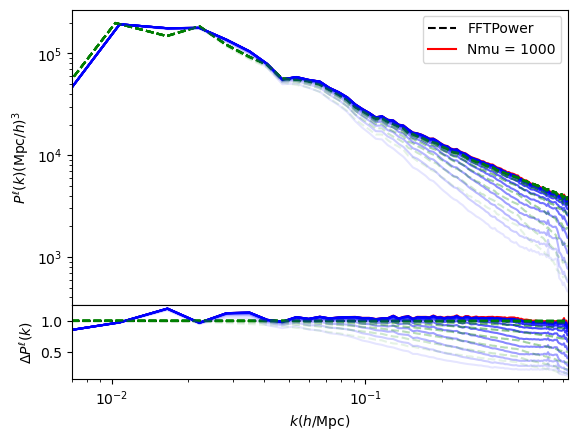

In [45]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios = [4,1])
gs.update(hspace = 0, wspace = 0)

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

kvals, lin_pk_fid_power = plot_Pk(tracer_field_eul_norm_zspace, ax0, ax1, color = 'black', label = 'FFTPower')
ax1.axhline(1, color = 'black', linestyle = '--')

# for Nmu, alpha in zip([5, 50, 100, 500, 1000], [0.2, 0.4, 0.6, 0.8, 1]):
lin_pk = FFTPower(gal_field.r2c(), '2d', kmin = 1e-5, kmax = 0.64, poles = [l], Nmu = Nmu)

# try computing P(k) from P(k, mu)
P_k = lin_pk.power.average('mu')
ax0.loglog(P_k['k'], P_k['power']*norm, label = 'Nmu = '+str(Nmu), color = 'red')
ax1.plot(P_k['k'], P_k['power']*norm/lin_pk_fid_power, color = 'red')
    
for i in range(len(lambda_FOGs)):
    theory = RSD_theory(lin_pk, f_sat, lambda_FOGs[i])
    delta_FOG = delta_FOG_func(tracer_field_eul_norm_zspace, lambda_FOG = lambda_FOGs[i])
    if lambda_FOG == 1:
        ax0.loglog(P_k['k'], theory, label = '$\lambda_\mathrm{{FOG}}=[0.1, 1]h$/Mpc', color = 'blue', alpha = alpha[i])
        kvals, lin_pk_RSD_power = plot_Pk(delta_FOG, ax0, ax1, color = 'green', 
                                      label = 'FFTPower, $\lambda_\mathrm{{FOG}}=[0.1, 2.2]h$/Mpc', alpha = alpha[i])
    else:
        ax0.loglog(P_k['k'], theory, color = 'blue', alpha = alpha[i])
        kvals, lin_pk_RSD_power = plot_Pk(delta_FOG, ax0, ax1, color = 'green', alpha = alpha[i])
    ax1.plot(P_k['k'], theory/lin_pk_fid_power, color = 'blue', alpha = alpha[i])
    ax1.plot(kvals, lin_pk_RSD_power/lin_pk_fid_power, color = 'green', linestyle = '--', alpha = alpha[i])

ax0.legend()
ax0.set_ylabel(r'$P^{\ell}(k) $(Mpc$/h)^3$')
ax0.set_xlim(7e-3, 0.63)
ax0.set_xticks([])

ax1.set_xlabel('$k (h/$Mpc)')
ax1.set_ylabel(r'$\Delta P^{\ell}(k)$')
ax1.set_xlim(7e-3, 0.63)
ax1.set_xscale('log')
plt.show()

## Compare to earlier plots

In [46]:
def RSD_ell_theory(tracer_field_eul_norm_zspace, tracer_field_eul_norm, ax0 = None, ax1 = None, f_sat = 0.7, lambda_FOG = 0.3, alpha = 1, i = 0, 
            plot = True, N = N, Lbox = Lbox, Nbox = Nbox, title = None, ell = 0, version = 0, xlim = (0, 0.63), ylabel = True, ax2 = None, ax3 = None,
            ax4 = None, ax5 = None, legend = True, norm = norm):
    
    # Start with large-scale RSDs
    RSD_large = tracer_field_eul_norm_zspace*(1-f_sat)
    if plot == True:
        plot_field(RSD_large, figsize=(6,6), title=r'$(1-f_s) \delta_{\mathrm{g}}(\vec{s}_c)$', plot = 'xz',
                   show_labels=False)
    
    # Now compute small-scale RSDs
    print(lambda_FOG)
    RSD_small = f_sat*ndimage.convolve1d(tracer_field_eul_norm_zspace, kernel_func(s_z_func(N), lambda_FOG), mode = 'wrap')
    if plot == True:
        plot_field(RSD_small, figsize=(6,6), title=r'$f_s \delta_{\mathrm{g}}(\vec{s}_c) *_z e^{(-\lambda_{\mathrm{FoG}} \mathrm{~s}_{\mathrm{z}})}$',
                   show_labels=False, plot = 'xz')
        
    # Add them together to get full RSDs
    delta_FOG = RSD_large+RSD_small
    if plot == True:
        plot_field(delta_FOG, figsize=(6,6), title=rf'$\delta_\mathrm{{tr}}^\mathrm{{FOG}}$, b={bias_params}', plot = 'xz',
                       show_labels=False)
        
    # Plot clustering
    def power_spectrum_err(ax0, ax1, tracer_field_eul_norm_zspace, label, color, l, ylabel, comm = MPI.COMM_WORLD, linestyle = '-', title = title, 
                           legend = legend, Nmu = 50): #sm
        
        def lin_pk_func(tracer_field_eul_norm_zspace, l):

            pm = pmesh.pm.ParticleMesh([Nbox, Nbox, Nbox], Lbox, dtype='float32', resampler='cic', comm=comm)

            # initialize a RealField
            gal_field = pmesh.pm.RealField(pm)
            gal_field[...] = tracer_field_eul_norm_zspace

            # Create the FFTPower objects
            lin_pk = FFTPower(gal_field.r2c(), '2d', kmin = 1e-5, kmax = 0.64, poles = [l], Nmu = Nmu)

            # k arrays are set like this
            kvals = lin_pk.poles['k'] # let's ignore the artificial zero k value

            lin_pk
            return lin_pk.poles['power_'+str(l)].real*norm, kvals, lin_pk

        lin_pk_pole_z, kvals_z, lin_pk_z = lin_pk_func(tracer_field_eul_norm_zspace, l)
        lin_pk_pole_real, kvals_real, lin_pk_real = lin_pk_func(tracer_field_eul_norm, l)

        if (kvals_z!=kvals_real).any():
            raise TypeError("make sure the kvals are the same")

        # Plot the P(k)
        ax0.loglog(kvals_z, lin_pk_pole_z, linestyle = linestyle, label = label, alpha = alpha, color = color) # lin_pk.power['power'].real[1:]

        # Plot the ratio
        ax1.plot(kvals_z, lin_pk_pole_z/lin_pk_pole_real, linestyle = linestyle, label = label, alpha = alpha, color = color) # lin_pk.power['power'].real[1:]
        
        # try computing P(k) from P(k, mu)
        if label == 'z-space (central distortion)':
            P_k = lin_pk_z.power.average('mu')
            theory = RSD_theory(lin_pk_z, f_sat, lambda_FOG)
            ax0.loglog(P_k['k'], theory, label = '$\lambda_\mathrm{{FOG}}={:.2f}h$/Mpc'.format(lambda_FOG), color = 'black', linestyle = '--')
            ax1.plot(P_k['k'], theory/lin_pk_pole_real, color = 'black', linestyle = '--')
        
        if i == 0:
            ax0.set_xlim(xlim)
            ax0.set_xticklabels([])
            ax0.set_title(title)

            ax1.set_xlim(xlim)
            ax1.set_ylim(0.75, 1.2)
            ax1.set_xlabel('$k (h/$Mpc)')
            ax1.set_xscale('log')
            
            if (ylabel == True and version == 0 and alpha == 1) or (legend == True and version != 0 and alpha == 1) or (version == 2):
                ax0.legend()
                ax0.set_ylabel(r'$P^{\ell}(k)$(Mpc$/h)^3$')
                ax1.set_ylabel('$P^{\ell}(k)_\mathrm{z}/P^{\ell}(k)_\mathrm{real}$')
            
        if (l != 0 and version == 0) or (legend == False and version == 1):
            ax0.set_yticklabels([])
            ax1.set_yticklabels([])
        
        return kvals_z
        
    if plot == True:
        
        fig = plt.figure()
        gs = gridspec.GridSpec(2, 1, height_ratios = [4,1])
        gs.update(hspace = 0)

        ax0 = fig.add_subplot(gs[0])
        ax1 = fig.add_subplot(gs[1])

    if version == 0:
        power_spectrum_err(ax0, ax1, delta_FOG, label = 'z-space (central distortion + FOG)', color = 'red', l = ell, ylabel = ylabel)
        power_spectrum_err(ax0, ax1, tracer_field_eul_norm_zspace, label = 'z-space (central distortion)', color = 'blue', l = ell, ylabel = ylabel)
        kvals_z = power_spectrum_err(ax0, ax1, tracer_field_eul_norm, label = 'real-space', color = 'green', l = ell, ylabel = ylabel)
        
    else:
        power_spectrum_err(ax0, ax1, delta_FOG, label = '$\ell=0$', color = 'purple', l = 0, ylabel = True, 
                           title = 'z-space (central distortion + FOG)', legend = False)
        power_spectrum_err(ax0, ax1, delta_FOG, label = '$\ell=2$', color = 'red', l = 2, ylabel = True, 
                           title = 'z-space (central distortion + FOG)', legend = None)
        kvals_z = power_spectrum_err(ax0, ax1, delta_FOG, label = '$\ell=4$', color = 'green', l = 4, ylabel = True, 
                                     title = 'z-space (central distortion + FOG)', legend = None)
        
        if version == 1:
            power_spectrum_err(ax2, ax3, tracer_field_eul_norm_zspace, label = '$\ell=0$', color = 'purple', l = 0, ylabel = ylabel, 
                               title = 'z-space (central distortion)', legend = False)
            power_spectrum_err(ax2, ax3, tracer_field_eul_norm_zspace, label = '$\ell=2$', color = 'red', l = 2, ylabel = ylabel, 
                               title = 'z-space (central distortion)', legend = None)
            power_spectrum_err(ax2, ax3, tracer_field_eul_norm_zspace, label = '$\ell=4$', color = 'green', l = 4, ylabel = ylabel, 
                               title = 'z-space (central distortion)', legend = None)

            power_spectrum_err(ax4, ax5, tracer_field_eul_norm, label = '$\ell=0$', color = 'purple', l = 0, ylabel = ylabel, title = 'real-space')
            power_spectrum_err(ax4, ax5, tracer_field_eul_norm, label = '$\ell=2$', color = 'red', l = 2, ylabel = ylabel, title = 'real-space')
            power_spectrum_err(ax4, ax5, tracer_field_eul_norm, label = '$\ell=4$', color = 'green', l = 4, ylabel = ylabel, title = 'real-space')
        
    return kvals_z

0.3


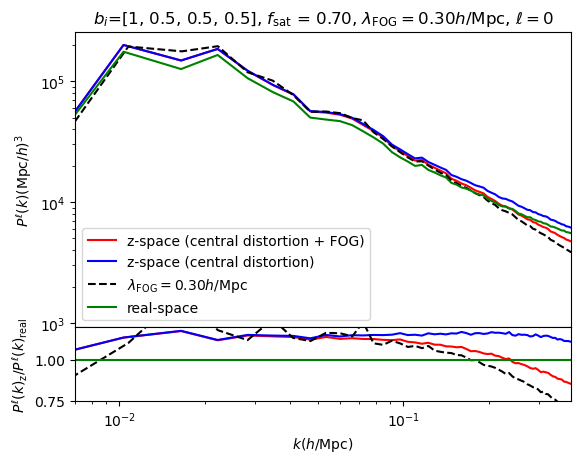

In [47]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios = [4,1])
gs.update(hspace = 0, wspace = 0)

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
xlim = (7e-3, 0.39)

RSD_ell_theory(tracer_field_eul_norm_zspace, tracer_field_eul_norm, ax0, ax1, plot = plot, ell = 0, xlim = xlim,
        title = '$b_i$={:s}, $f_\mathrm{{sat}}$ = {:.2f}, $\lambda_\mathrm{{FOG}}={:.2f} h/$Mpc, $\ell=${:d}'.format(str(bias_params), 0.7, 0.3, 0))
plt.show()

In [48]:
# Plot clustering
def power_spectrum_err(ax0, ax1, tracer_field_eul_norm_zspace, label, color, l, ylabel, tracer_field_eul_norm = tracer_field_eul_norm, comm = MPI.COMM_WORLD, linestyle = '-', 
                       legend = True, Nmu = 5, version = 0, alpha = 1): #sm

    def lin_pk_func(tracer_field_eul_norm_zspace, l):

        pm = pmesh.pm.ParticleMesh([Nbox, Nbox, Nbox], Lbox, dtype='float32', resampler='cic', comm=comm)

        # initialize a RealField
        gal_field = pmesh.pm.RealField(pm)
        gal_field[...] = tracer_field_eul_norm_zspace

        # Create the FFTPower objects
        lin_pk = FFTPower(gal_field.r2c(), '2d', kmin = 1e-5, kmax = 0.64, poles = [l], Nmu = Nmu)

        # k arrays are set like this
        kvals = lin_pk.poles['k'] # let's ignore the artificial zero k value

        return lin_pk.poles['power_'+str(l)].real*norm, kvals, lin_pk

    lin_pk_pole_z, kvals_z, lin_pk_z = lin_pk_func(tracer_field_eul_norm_zspace, l = l)
    lin_pk_pole_real, kvals_real, lin_pk_power_real = lin_pk_func(tracer_field_eul_norm, l = l)

    if (kvals_z!=kvals_real).any():
        raise TypeError("make sure the kvals are the same")

    # Plot the P(k)
    ax0.plot(kvals_z, kvals_z*lin_pk_pole_z, linestyle = linestyle, label = label, alpha = alpha, color = color) # lin_pk.power['power'].real[1:]

    # Plot the ratio
    ax1.plot(kvals_z, lin_pk_pole_z/lin_pk_pole_real, linestyle = linestyle, label = label, alpha = alpha, color = color) # lin_pk.power['power'].real[1:]

    return lin_pk_z, kvals_real, lin_pk_pole_real

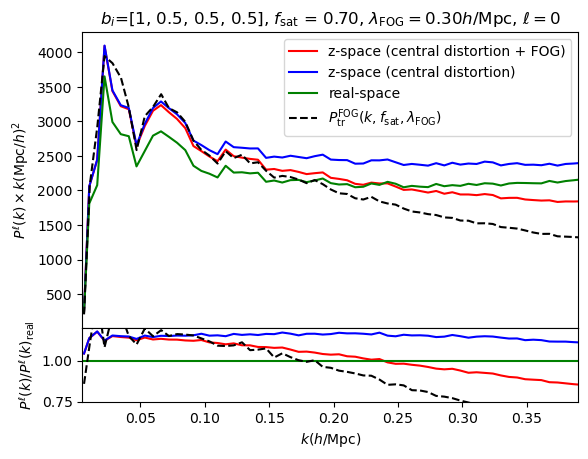

In [49]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios = [4,1])
gs.update(hspace = 0, wspace = 0)

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
xlim = (5e-3, 0.39)

f_sat = 0.7
lambda_FOG = 0.3

# Add them together to get full RSDs
delta_FOG = delta_FOG_func(tracer_field_eul_norm_zspace)

power_spectrum_err(ax0, ax1, delta_FOG, label = 'z-space (central distortion + FOG)', color = 'red', l = l, ylabel = ylabel)
lin_pk_z, kvals_real, lin_pk_pole_real = power_spectrum_err(ax0, ax1, tracer_field_eul_norm_zspace, label = 'z-space (central distortion)', color = 'blue', l = l, ylabel = ylabel, Nmu = 1000)
power_spectrum_err(ax0, ax1, tracer_field_eul_norm, label = 'real-space', color = 'green', l = l, ylabel = ylabel)

# try computing P(k) from P(k, mu)
P_k = lin_pk_z.power.average('mu')
theory = RSD_theory(lin_pk_z, f_sat, lambda_FOG)
ax0.plot(P_k['k'], P_k['k']*theory, label = '$P_\mathrm{{tr}}^\mathrm{{FOG}}(k, f_\mathrm{{sat}}, \lambda_\mathrm{{FOG}})$', color = 'black', linestyle = '--')
ax1.plot(P_k['k'], theory/lin_pk_pole_real, color = 'black', linestyle = '--')
        
ax0.legend()
ax0.set_xlim(xlim)
ax0.set_xticklabels([])
ax0.set_title('$b_i$={:s}, $f_\mathrm{{sat}}$ = {:.2f}, $\lambda_\mathrm{{FOG}}={:.2f} h/$Mpc, $\ell=${:d}'.format(str(bias_params), f_sat, lambda_FOG, 0))
ax0.set_ylabel(r'$P^{\ell}(k)\times k $(Mpc$/h)^2$')

ax1.set_xlim(xlim)
ax1.set_ylim(0.75, 1.2)
ax1.set_xlabel('$k (h/$Mpc)')
ax1.set_ylabel('$P^{\ell}(k)/P^{\ell}(k)_\mathrm{real}$')

plt.show()

Questions:
- should I be zooming in or smoothing more? (zslicemax = 3?)
- why do we take the absolute value of the kernel?
- why doesn't amplitude of P(k) change with $f_\mathrm{sat}$?
- do people ever add up multipoles, or always plotted separately?
- why doesn't P(k) RSD model match measured P(k) from implemented RSD model?